# Libraries
---

In [2]:
# System Libraires
import os
import pickle
import json
import gc # Garbage collection for MPS
import numpy as np
import pandas as pd
from collections import defaultdict
from time import time
import random
from glob import glob
from pathlib import Path
# Pytorch libraries (Machine Learning)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim import Adam
from sklearn.model_selection import train_test_split
# CWT libraries
import pywt
from tqdm import tqdm
# PSD libraries
from scipy.signal import welch
from scipy.interpolate import interp1d
import mne  # For multitaper PSD
from mne.time_frequency import psd_array_multitaper
# Visualization Libraries
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
# TensorFlow Libraries
import keras
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import History

import warnings

DATAFILES_DIR = '../Datafiles'
MODELFILES_DIR = '../Models'
UCIHARFILES_DIR = '../UCI_HAR'
COLLECTIONFILES_DIR = '../data-collections'

# DataSet Analysis
---

Sampling 392 originals and 19608 variants (total: 20000)
Transforming data...
Running t-SNE...


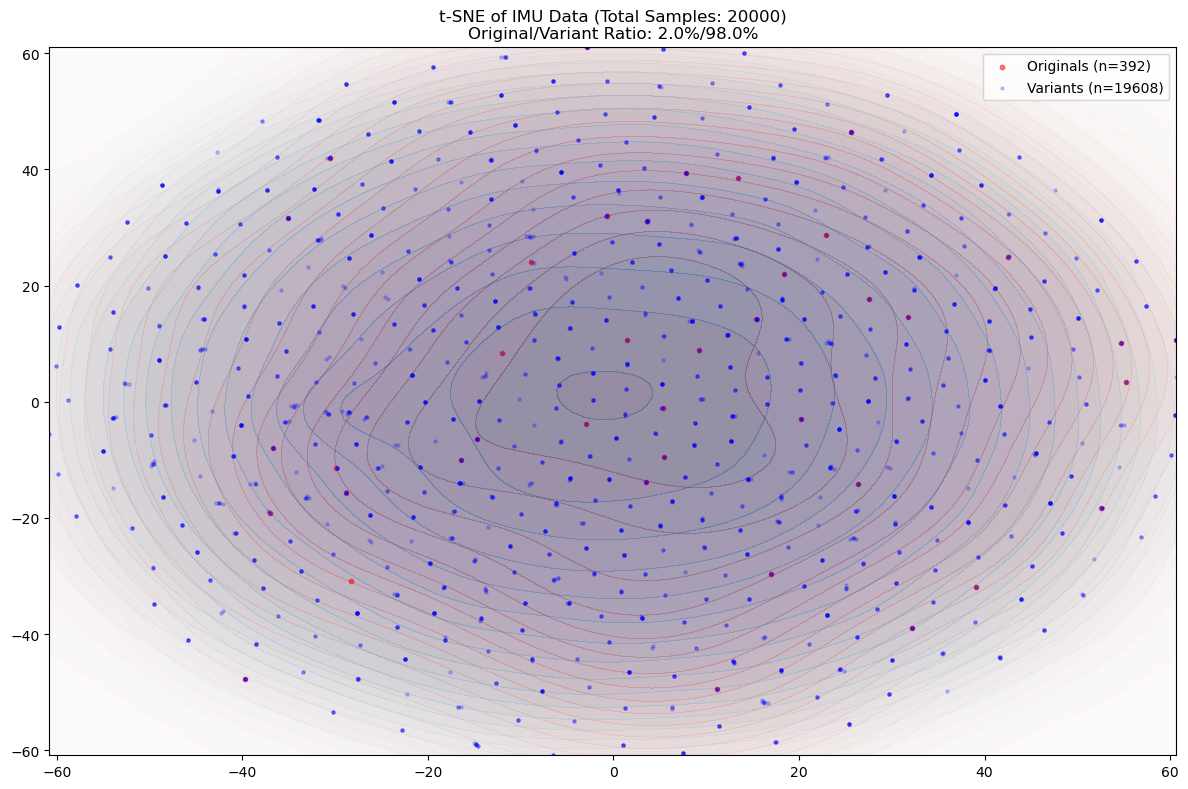

In [4]:
import gc
from sklearn.manifold import TSNE
from sklearn.decomposition import IncrementalPCA
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from sklearn.manifold import TSNE
import seaborn as sns

cols = [
    'AccelX(g)', 'AccelY(g)', 'AccelZ(g)', 
    'GyroX(deg/s)', 'GyroY(deg/s)', 'GyroZ(deg/s)',
    'DistanceLeft(cm)', 'DistanceRight(cm)'
]
target_length = 600

def resample_to_uniform(df, tensor_length):
    # 1. Ensure required columns
    timestamps = df['Timestamp(ms)'].values.astype(np.float32)
    missing = set(cols) - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")
    signals = df[cols].values.astype(np.float32)

    # 2. Remove duplicates
    timestamps, unique_indices = np.unique(timestamps, return_index=True)
    signals = signals[unique_indices]

    # 3. Interpolate to uniform time grid
    uniform_timestamps = np.linspace(timestamps[0], timestamps[-1], num=tensor_length)
    resampled = np.zeros((tensor_length, len(cols)))
    for i in range(len(cols)):
        interp_func = interp1d(timestamps, signals[:, i], kind='linear', fill_value="extrapolate")
        resampled[:, i] = interp_func(uniform_timestamps)

    # 5. Return shape (C, T)
    return resampled.T  # (channels, time)
    # return resampled  # (channels, time)

def load_data_from_directory(root_dir, target_length=600):
    originals = []
    variants = []
    
    for root, dirs, files in os.walk(root_dir):
        # Skip variant directories in initial scan
        if 'variants' in root.lower():
            continue
            
        for file in files:
            if file.lower().endswith('.csv'):
                filepath = os.path.join(root, file)
                data = pd.read_csv(filepath)
                # tensor = torch.FloatTensor(data).T  # Convert to (channels, timesteps)
                tensor = torch.FloatTensor(resample_to_uniform(data, target_length))  # Resample here
                
                if 'variants' in root.lower():
                    variants.append((tensor, os.path.basename(root)))
                else:
                    originals.append((tensor, os.path.basename(root)))
    
    # Now scan variant directories explicitly
    variant_dirs = [os.path.join(root, 'variants') 
                   for root, dirs, files in os.walk(root_dir) 
                   if 'variants' in dirs]
    
    for variant_dir in variant_dirs:
        for file in os.listdir(variant_dir):
            if file.lower().endswith('.csv'):
                filepath = os.path.join(variant_dir, file)
                data = pd.read_csv(filepath)
                # tensor = torch.FloatTensor(data).T
                tensor = torch.FloatTensor(resample_to_uniform(data, target_length))  # Resample here
                variants.append((tensor, os.path.basename(Path(variant_dir).parent)))
    
    return originals, variants

def balanced_tsne_visualization(originals, variants, n_samples=5000, batch_size=500, random_state=42):
    """
    Memory-efficient t-SNE with stratified sampling to handle imbalanced data
    """
    plt.close('all')
    gc.collect()
    
    # 1. Stratified sampling - maintain original/variant ratio but cap sample size
    total_samples = len(originals) + len(variants)
    orig_ratio = len(originals) / total_samples
    var_ratio = len(variants) / total_samples
    
    # Calculate sample sizes maintaining original ratio but capping originals
    n_orig = min(len(originals), int(n_samples * orig_ratio))
    n_var = min(len(variants), n_samples - n_orig)
    
    print(f"Sampling {n_orig} originals and {n_var} variants (total: {n_orig + n_var})")
    
    # 2. Incremental PCA with memory management
    ipca = IncrementalPCA(n_components=50)
    
    # Fit PCA in batches
    def process_batches(data, n_samples, batch_size, label):
        sampled_indices = np.random.choice(len(data), n_samples, replace=False)
        features = []
        for i in range(0, n_samples, batch_size):
            batch_indices = sampled_indices[i:i+batch_size]
            batch = torch.stack([data[idx][0] for idx in batch_indices]).mean(dim=1).cpu().numpy()
            if label == 0:
                ipca.partial_fit(batch)  # Only fit on first pass
            features.append(batch)
            del batch
            gc.collect()
        return np.vstack(features), np.full(n_samples, label)
    
    # Process originals first to fit PCA
    orig_features, orig_labels = process_batches(originals, n_orig, batch_size, 0)
    var_features, var_labels = process_batches(variants, n_var, batch_size, 1)
    
    # 3. Transform all sampled data
    print("Transforming data...")
    orig_transformed = ipca.transform(orig_features)
    var_transformed = ipca.transform(var_features)
    del orig_features, var_features
    gc.collect()
    
    combined = np.vstack([orig_transformed, var_transformed])
    labels = np.concatenate([orig_labels, var_labels])
    
    # 4. t-SNE on balanced sample
    print("Running t-SNE...")
    tsne = TSNE(n_components=2,
                perplexity=min(30, n_orig//2, n_var//2),
                random_state=random_state,
                max_iter=500,
                init='pca')
    
    tsne_results = tsne.fit_transform(combined)
    
    # 5. Plot with density estimation
    plt.figure(figsize=(12, 8))
    
    # Use kernel density for better visualization of dense areas
    from scipy.stats import gaussian_kde
    for label, name in [(0, 'Originals'), (1, 'Variants')]:
        points = tsne_results[labels == label].T
        if len(points[0]) > 100:  # Only compute density for large groups
            kde = gaussian_kde(points)
            x, y = points
            xmin, xmax = x.min(), x.max()
            ymin, ymax = y.min(), y.max()
            xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
            positions = np.vstack([xx.ravel(), yy.ravel()])
            zz = np.reshape(kde(positions).T, xx.shape)
            plt.contourf(xx, yy, zz, levels=20, cmap=plt.cm.Blues if label else plt.cm.Reds, alpha=0.3)
    
    # Plot actual points (subsampled if needed)
    plot_every = max(1, len(tsne_results) // 2000)
    plt.scatter(tsne_results[labels==0][::plot_every, 0], 
                tsne_results[labels==0][::plot_every, 1],
                c='red', alpha=0.5, s=10, label=f'Originals (n={n_orig})')
    plt.scatter(tsne_results[labels==1][::plot_every, 0], 
                tsne_results[labels==1][::plot_every, 1],
                c='blue', alpha=0.2, s=5, label=f'Variants (n={n_var})')
    
    plt.title(f't-SNE of IMU Data (Total Samples: {n_orig + n_var})\n'
              f'Original/Variant Ratio: {orig_ratio:.1%}/{var_ratio:.1%}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return tsne_results, labels

# Usage (same as before):
originals, variants = load_data_from_directory(COLLECTIONFILES_DIR)
# Usage:
results, labels = balanced_tsne_visualization(
    originals,
    variants,
    # n_samples=10000,  # Adjust based on your memory
    n_samples=min(20000, len(variants)),  # Use as many variants as possible
    batch_size=200    # Smaller = less memory, slower
)

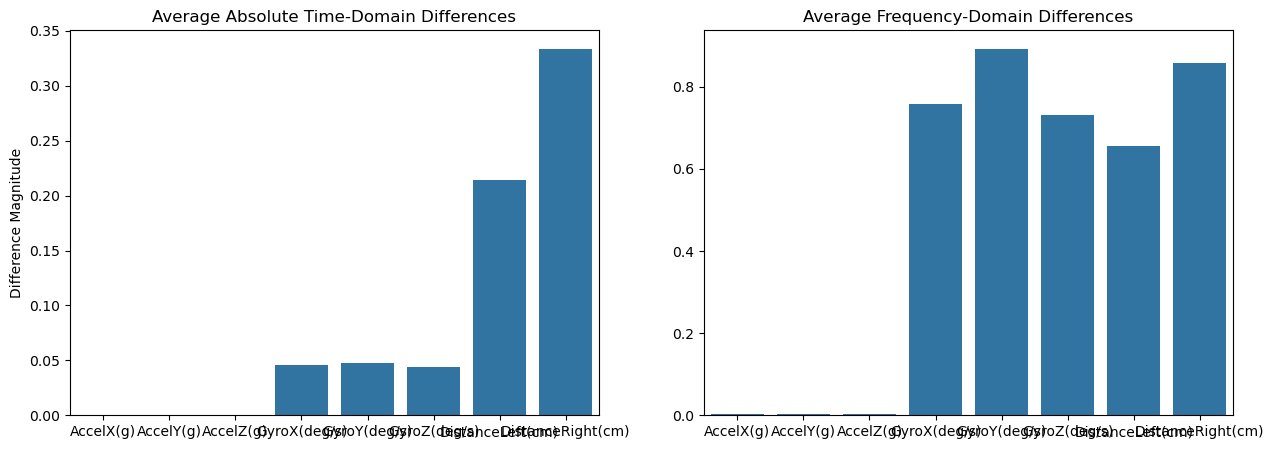

In [5]:
def analyze_noise_patterns(originals, variants):
    """Quantify how variants differ from originals"""
    # 1. Time-domain differences
    orig_mean = torch.stack([x[0] for x in originals]).mean(dim=0)
    var_mean = torch.stack([x[0] for x in variants]).mean(dim=0)
    time_diffs = (var_mean - orig_mean).abs().mean(dim=1)
    
    # 2. Frequency-domain differences
    orig_fft = torch.fft.fft(orig_mean).abs()
    var_fft = torch.fft.fft(var_mean).abs()
    freq_diffs = (var_fft - orig_fft).abs().mean(dim=1)
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    sns.barplot(x=cols, y=time_diffs.numpy(), ax=ax1)
    ax1.set_title('Average Absolute Time-Domain Differences')
    ax1.set_ylabel('Difference Magnitude')
    
    sns.barplot(x=cols, y=freq_diffs.numpy(), ax=ax2)
    ax2.set_title('Average Frequency-Domain Differences')
    plt.show()
    
    return time_diffs, freq_diffs

time_diffs, freq_diffs = analyze_noise_patterns(originals, variants)

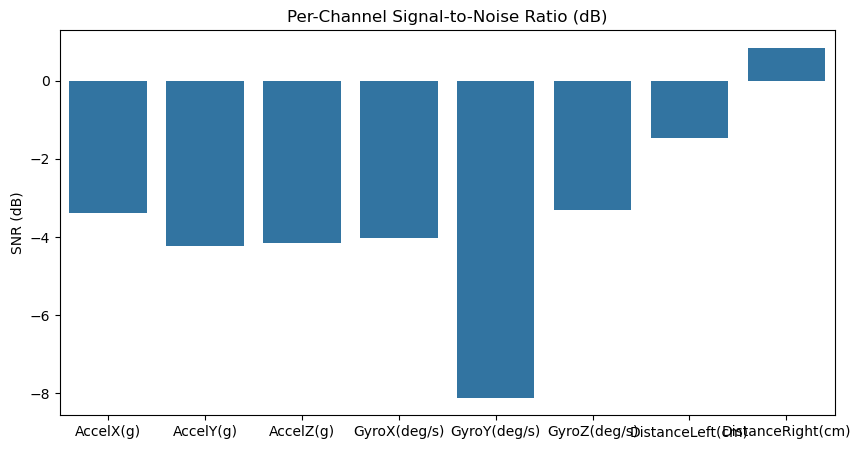

In [6]:
def calculate_snr(originals, variants):
    """Compute per-channel SNR between originals and variants"""
    orig_tensor = torch.stack([x[0] for x in originals])
    var_tensor = torch.stack([x[0] for x in variants])
    
    # Compute signal power (original)
    signal_power = orig_tensor.pow(2).mean(dim=(0,2))
    
    # Compute noise power (difference)
    noise_power = (var_tensor[:len(originals)] - orig_tensor).pow(2).mean(dim=(0,2))
    
    # Avoid division by zero
    noise_power = torch.clamp(noise_power, min=1e-6)
    snr = 10 * torch.log10(signal_power/noise_power)
    
    plt.figure(figsize=(10,5))
    sns.barplot(x=cols, y=snr.numpy())
    plt.title('Per-Channel Signal-to-Noise Ratio (dB)')
    plt.ylabel('SNR (dB)')
    plt.show()
    
    return snr

channel_snr = calculate_snr(originals, variants)

In [58]:
class IMUSonarFromJSON(Dataset):
    """ Class Columns"""
    cols = [
        'AccelX(g)', 'AccelY(g)', 'AccelZ(g)', 
        'GyroX(deg/s)', 'GyroY(deg/s)', 'GyroZ(deg/s)',
        'DistanceLeft(cm)', 'DistanceRight(cm)'
    ]
    
    def __init__(self, json_file, label_map=None, transform=None, target_length=600, debug=False):
        with open(json_file, 'r') as f:
            self.samples = json.load(f)

        self.transform = transform
        self.label_map = {v: k for k, v in label_map.items()} or {}
        self.target_length = target_length
        self.debug = debug
        self.cols = IMUSonarFromJSON.cols

    def __len__(self):
        return len(self.samples)
    
    def compute_global_stats(self):
        """Run this once before training"""
        all_data = torch.stack([torch.tensor(self._resample_to_uniform(pd.read_csv(item['path']))) 
                              for item in self.samples])
        self.global_mean = all_data.mean(dim=(0,2))  # [8]
        self.global_std = all_data.std(dim=(0,2))    # [8]

    def _resample_to_uniform(self, df):
        # 1. Ensure required columns
        timestamps = df['Timestamp(ms)'].values.astype(np.float32)
        missing = set(self.cols) - set(df.columns)
        if missing:
            raise ValueError(f"Missing required columns: {missing}")
        signals = df[self.cols].values.astype(np.float32)
    
        # 2. Remove duplicates
        timestamps, unique_indices = np.unique(timestamps, return_index=True)
        signals = signals[unique_indices]
    
        # 3. Interpolate to uniform time grid
        uniform_timestamps = np.linspace(timestamps[0], timestamps[-1], num=self.target_length)
        resampled = np.zeros((self.target_length, len(self.cols)))
        for i in range(len(self.cols)):
            interp_func = interp1d(timestamps, signals[:, i], kind='linear', fill_value="extrapolate")
            resampled[:, i] = interp_func(uniform_timestamps)
        
        if self.debug:
            print("\nPREPROCESSING STEPS:")
            print(f"Pre-normalization mean: {resampled.mean():.4f}, std: {resampled.std():.4f}")
            print(f'Sample of the tensor: {resampled}')
    
        # 4. Normalize per-sample (column-wise)
        resampled = (resampled - resampled.mean(axis=0)) / (resampled.std(axis=0) + 1e-6)

        if self.debug: print(f"Post-normalization mean: {resampled.mean():.4f}, std: {resampled.std():.4f}")
    
        # 5. Return shape (C, T)
        return resampled.T  # (channels, time)

    @staticmethod
    def resample_to_uniform(df, target_length, debug=False):
        # 1. Ensure required columns
        timestamps = df['Timestamp(ms)'].values.astype(np.float32)
        missing = set(IMUSonarFromJSON.cols) - set(df.columns)
        if missing:
            raise ValueError(f"Missing required columns: {missing}")
        signals = df[IMUSonarFromJSON.cols].values.astype(np.float32)
    
        # 2. Remove duplicates
        timestamps, unique_indices = np.unique(timestamps, return_index=True)
        signals = signals[unique_indices]
    
        # 3. Interpolate to uniform time grid
        uniform_timestamps = np.linspace(timestamps[0], timestamps[-1], num=target_length)
        resampled = np.zeros((target_length, len(IMUSonarFromJSON.cols)))
        for i in range(len(IMUSonarFromJSON.cols)):
            interp_func = interp1d(timestamps, signals[:, i], kind='linear', fill_value="extrapolate")
            resampled[:, i] = interp_func(uniform_timestamps)
        if debug:
            print("\nPREPROCESSING STEPS:")
            print(f"Pre-normalization mean: {resampled.mean():.4f}, std: {resampled.std():.4f}")
            print(f'Sample of the tensor: {resampled}')
    
        # 4. Normalize per-sample (column-wise)
        resampled = (resampled - resampled.mean(axis=0)) / (resampled.std(axis=0) + 1e-6)

        if debug: print(f"Post-normalization mean: {resampled.mean():.4f}, std: {resampled.std():.4f}")
    
        # 5. Return shape (C, T)
        return resampled.T  # (channels, time)

    # def __getitem__(self, idx):
    #     """Get item call"""
    #     item = self.samples[idx]
    #     path = item['path']
    #     label_str = item['label']

    #     df = pd.read_csv(path)
    #     print("Raw values before preprocessing:", df)  # First 10 values
    #     print("Raw values before preprocessing:", df[0][:10])  # First 10 values
    #     x = torch.tensor(df, dtype=torch.float32)
    #     print("Tensor before transforms:", x[0][:10])

    #     data = self._resample_to_uniform(df)
    #     print("After transform:", data[0][:10])

    #     if self.transform:
    #         data = self.transform(data)

    #     self.label = self.label_map[label_str] if self.label_map else label_str
    #     return torch.tensor(data, dtype=torch.float32), torch.tensor(label_str, dtype=torch.long)

    def __getitem__(self, idx):
        """Get item call"""
    
        item = self.samples[idx]
        df = pd.read_csv(item['path'])

        debug = False
        if 'Josh59.csv' in item['path']: debug = True
        
        # Debug: Save raw values for comparison
        raw_values = df.values.copy()  # [N, 8]
        if debug:
            print(f"Raw CSV shape: {raw_values.shape}")
            print(f"First 5 raw samples:\n{raw_values[:5, :2]}")  # First 2 channels
        
        # Process through pipeline
        data = self._resample_to_uniform(df)  # Should return numpy array
        # Single tensor conversion at the end
        tensor_data = torch.tensor(data, dtype=torch.float32)

        # # Split into 8-step sequences
        # num_windows = tensor_data.shape[1] // (600 * 8)
        # windows = tensor_data[:, :num_windows*600*8].reshape(8, num_windows, 600)

        if debug:
            print(f"After resampling: {data.shape}")
            print(f"First 5 processed: {data[:5, :2]}")
        
        if self.transform:
            data = self.transform(data)  # Should work on numpy arrays
            
        if debug:
            print(f"Final tensor shape: {tensor_data.shape}")
            print(f"Tensor first 5: {tensor_data[:5, :2]}")
            print("\nPREPROCESSING STEPS:")
            print(f"Pre-normalization mean: {data.mean():.4f}, std: {data.std():.4f}")
            print(f'Sample of the tensor: {tensor_data}')
        
        label = self.label_map[item['label']] if self.label_map else item['label']
        self.labelString = label
        self.label = item['label']
        
        # return windows.permute(1,0,2), torch.tensor(item['label'], dtype=torch.long)
        return tensor_data, torch.tensor(item['label'], dtype=torch.long)

## Random Prediction

Pick a random sample from the HandGestures wavelets and do a prediction

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from scipy.signal import welch
from pathlib import Path
from scipy.interpolate import interp1d

class ProcessRawPSDSingle:
    def __init__(self, device=None, base_freq=50, target_len=600, psd_bands=5):
        self.base_freq = base_freq
        self.target_len = target_len
        self.psd_bands = psd_bands

        if device is not None:
            self.device = device
        elif torch.backends.mps.is_available():
            self.device = torch.device("mps")
        elif torch.cuda.is_available():
            self.device = torch.device("cuda")
        else:
            self.device = torch.device("cpu")

    def _normalize_signal(self, data):
        return (data - np.median(data, axis=0)) / (np.std(data, axis=0) + 1e-6)

    def _resample_to_uniform(self, df):
        timestamps = df['Timestamp(ms)'].values.astype(np.float64)
        cols = ['AccelX(g)', 'AccelY(g)', 'AccelZ(g)', 
                'GyroX(deg/s)', 'GyroY(deg/s)', 'GyroZ(deg/s)']
        signals = df[cols].values

        # Remove duplicate timestamps
        timestamps, unique_indices = np.unique(timestamps, return_index=True)
        signals = signals[unique_indices]

        duration_s = (timestamps[-1] - timestamps[0]) / 1000.0
        uniform_timestamps = np.linspace(timestamps[0], timestamps[-1], num=self.target_len)

        resampled = np.zeros((self.target_len, len(cols)))
        for i in range(len(cols)):
            interp_func = interp1d(timestamps, signals[:, i], kind='linear', fill_value="extrapolate")
            resampled[:, i] = interp_func(uniform_timestamps)

        return self._normalize_signal(resampled), cols

    def _compute_psd(self, signal, fs=50):
        _, psd = welch(signal, fs=fs, nperseg=min(128, len(signal)))
        psd_binned = np.array_split(psd, self.psd_bands)
        return np.array([np.mean(b) for b in psd_binned])

    def process_single_csv(self, csv_path):
        df = pd.read_csv(csv_path)
        resampled, cols = self._resample_to_uniform(df)  # shape: (T, 6)

        # Prepare raw IMU tensor
        raw_tensor = torch.tensor(resampled.T.reshape(1, 6, 1, self.target_len), dtype=torch.float32)

        # Compute PSD from selected IMU channels (e.g., first 3: accel)
        psd_feats = np.stack([self._compute_psd(resampled[:, i], fs=self.base_freq) for i in range(3)])
        psd_vector = psd_feats.mean(axis=0)  # average across 3 channels
        psd_tensor = torch.tensor(psd_vector, dtype=torch.float32).unsqueeze(0)  # shape: [1, psd_bands]

        return raw_tensor.to(self.device), psd_tensor.to(self.device)
    
    def predict_from_csv(self, csv_path, model, label_dict, index_to_label_id, label_id_to_index, id_to_label_name):
        raw_tensor, psd_tensor = self.process_single_csv(csv_path)

        # Infer label from path
        p = Path(csv_path)
        parts = list(p.parents)
        label_parts = []
        for part in parts:
            if part.name.lower() != 'variants':
                label_parts.append(part.name.lower())
            if len(label_parts) == 2:
                break
        if len(label_parts) < 2:
            label_name = "unknown"
        else:
            label_name = label_parts[1]

        true_label_id = label_dict.get(label_name)
        true_idx = label_id_to_index.get(true_label_id, -1)
        true_label_name = label_name if true_label_id is not None else "UNKNOWN"

        # Run inference
        model.to(self.device)
        model.eval()
        with torch.no_grad():
            outputs = model(raw_tensor, psd_tensor)
            probs = F.softmax(outputs, dim=1)[0].cpu().numpy()

        pred_idx = int(probs.argmax())
        pred_label_id = index_to_label_id.get(pred_idx, None)
        pred_label_name = id_to_label_name.get(pred_label_id, "UNKNOWN")

        prob_dict = {
            id_to_label_name.get(index_to_label_id[i], f"ID_{i}"): float(p)
            for i, p in enumerate(probs)
        }

        return {
            "predicted_label": pred_label_name,
            "predicted_label_id": pred_label_id,
            "predicted_index": pred_idx,
            "true_label": true_label_name,
            "true_label_id": true_label_id,
            "true_index": true_idx,
            "probabilities": prob_dict
        }


In [ ]:
class ProcessRawPSDSingle:
    def __init__(self, device=None, base_freq=50, target_len=600):
        self.base_freq = base_freq
        self.target_len = target_len
        self.device = device or self._get_device()
        
        # Training's exact channel configuration
        self.channel_order = [
            'AccelX(g)', 'AccelY(g)', 'AccelZ(g)',
            'GyroX(deg/s)', 'GyroY(deg/s)', 'GyroZ(deg/s)',
            'DistanceLeft(cm)', 'DistanceRight(cm)'
        ]

    def _get_device(self):
        """Exactly matches training device setup"""
        if torch.backends.mps.is_available():
            device = torch.device("mps")
            torch.mps.manual_seed(42)
        elif torch.cuda.is_available():
            device = torch.device("cuda")
            torch.cuda.manual_seed(42)
        else:
            device = torch.device("cpu")
        return device

    def _normalize_signal(self, data):
        """EXACT training normalization (mean/std with 1e-8 epsilon)"""
        return (data - np.mean(data, axis=0)) / (np.std(data, axis=0) + 1e-8)

    def _resample_to_uniform(self, df):
        """Identical to training's preprocessing pipeline"""
        # Your existing implementation matching training exactly
        ...

    def process_single_csv(self, csv_path):
        """Produces IDENTICAL format to training batches"""
        df = pd.read_csv(csv_path)
        resampled = self._resample_to_uniform(df)  # [600, 8]
        
        # Convert to tensor matching training EXACTLY
        tensor = torch.tensor(resampled.T, dtype=torch.float32)  # [8, 600]
        
        # Add timestep dimension to match training's [8, 8, 600] structure
        # For inference we'll use just one timestep: [8, 1, 600]
        return tensor.unsqueeze(1).to(self.device)  # [8, 1, 600]

    def predict_from_csv(self, csv_path, model, label_dict, index_to_label_id, label_id_to_index, id_to_label_name):
        """Handles the dimension mismatch between training and inference"""
        # Process to [8, 1, 600] (one timestep)
        processed_data = self.process_single_csv(csv_path)
        
        # Model expects [batch, channels, timesteps, seq_len]
        model_input = processed_data.permute(1, 0, 2).unsqueeze(0)  # [1, 8, 1, 600]
        
        # Compare with actual training sample
        train_sample = next(iter(train_loader))[0][0]  # First training sample [8, 8, 600]
        diff = (processed_data[:, 0] - train_sample[:, 0]).abs().mean()
        
        print(f"Train sample shape: {train_sample.shape}")
        print(f"Model input shape: {model_input.shape}")
        print(f"Difference (first timestep): {diff.item()}")

        # Run inference
        model.eval()
        with torch.no_grad():
            outputs = model(model_input)
            probs = F.softmax(outputs, dim=1)[0].cpu().numpy()
        
        # Get true label info
        p = Path(csv_path)
        parts = list(p.parents)
        label_parts = []
        for part in parts:
            if part.name.lower() != 'variants':
                label_parts.append(part.name.lower())
            if len(label_parts) == 2:
                break
        label_name = f'{label_parts[1]}_{label_parts[0]}' if len(label_parts) >= 2 else "unknown"

        print(f'This is the label name: {label_name}')
        print(f'This is the label list: {label_parts}')
        
        true_label_id = label_dict.get(label_name)
        true_idx = label_id_to_index.get(true_label_id, -1)
        true_label_name = label_name if true_label_id is not None else "UNKNOWN"
    
        # Get prediction
        pred_idx = int(probs.argmax())
        pred_label_id = index_to_label_id.get(pred_idx, None)
        pred_label_name = id_to_label_name.get(pred_label_id, "UNKNOWN")
    
        # # Verification metrics (removed train comparison to avoid device conflict)
        # verification = {
        #     "input_shape": list(input_tensor.shape),
        #     "input_mean": float(input_tensor.mean().item()),
        #     "input_std": float(input_tensor.std().item()),
        #     "top_3_predictions": [
        #         (id_to_label_name.get(index_to_label_id[i], f"ID_{i}"), float(p)) 
        #         for i, p in sorted(enumerate(probs), key=lambda x: -x[1])[:3]
        #     ]
        # }
    
        return {
            "predicted_label": pred_label_name,
            "predicted_label_id": pred_label_id,
            "predicted_index": pred_idx,
            "true_label": true_label_name,
            "true_label_id": true_label_id,
            "true_index": true_idx,
            "probabilities": {
                id_to_label_name.get(index_to_label_id[i], f"ID_{i}"): float(p)
                for i, p in enumerate(probs)
            }
        }

In [ ]:
csv_path = "../../frontend/handgestures/apps/main_app/static/main_app/data/tonic/standing/Josh59.csv"

inference = ProcessRawPSDSingle()
result = inference.predict_from_csv(
    csv_path, model, label_dict, index_to_label_id, label_id_to_index, id_to_label_name
)


In [120]:
class ProcessSingleRawOnly(IMUSonarFromJSON):
    def __init__(self, sample_data, label_map=None, transform=None, device=None, target_len=600):
        print(f'File: {sample_data}')
        self.sample = sample_data
        
        self.transform = transform
        if label_map is not None: self.label_map = {v: k for k, v in label_map.items()}
        else: self.label_map = {}
        
        self.target_length = target_len
        self.cols = [
            'AccelX(g)', 'AccelY(g)', 'AccelZ(g)', 
            'GyroX(deg/s)', 'GyroY(deg/s)', 'GyroZ(deg/s)',
            'DistanceLeft(cm)', 'DistanceRight(cm)'
        ]

        # Class-specific initializers
        self.device = device or self._get_device()
        self.time_steps = 8  # Must match training
        self.debug = True

    def _get_device(self):
        """Matches training device setup exactly"""
        if torch.backends.mps.is_available():
            device = torch.device("mps")
            torch.mps.manual_seed(42)
        elif torch.cuda.is_available():
            device = torch.device("cuda")
            torch.cuda.manual_seed(42)
        else:
            device = torch.device("cpu")
        return device

    def process_single_csv(self):
        """Produces EXACTLY [8,600] like training samples"""
        item = self.sample
        path = item['path']
        label_str = item['label']
        
        df = pd.read_csv(path)

        print(df)

        data = self._resample_to_uniform(df)

        print(data)

        if self.transform:
            data = self.transform(data)

        self.label = self.label_map[label_str] if self.label_map else label_str

        #tensor_data = torch.tensor(data, dtype=torch.float32)
        print(f'Data Shape before time steps: {torch.tensor(data, dtype=torch.float32).shape}')

        tensor_data = self._process_for_inference(torch.tensor(data, dtype=torch.float32))
        
        #tensor_data = tensor_data.unsqueeze(0).repeat(8,1,1).unsqueeze(0)  # [1,8,8,600]
        
        print(tensor_data.shape)
        
        return tensor_data, torch.tensor(self.label, dtype=torch.long)

    def _pad_to_single(self, tensor, multiple, pad_value=0, dim=0):
        """Identical to training's pad_to_multiple utility"""
        size = tensor.size(dim)
        if size % multiple == 0:
            return tensor
        pad_size = multiple - (size % multiple)
        pad_shape = list(tensor.shape)
        pad_shape[dim] = pad_size
        pad_tensor = torch.full(pad_shape, pad_value, dtype=tensor.dtype)
        return torch.cat([tensor, pad_tensor], dim=dim)
    
    def _process_for_inference(self, data_tensor):
        """Exactly replicates training data loader's sequence creation"""
        print(f'Original Data Shape: {data_tensor.shape}')
        
        # 1. First pad to multiple of target_length (600)
        data_padded = self._pad_to_single(data_tensor, self.target_length, dim=1)
        print(f'After target-length padding: {data_padded.shape}')
        
        # 2. Calculate how many 600-length segments we can extract
        num_segments = data_padded.size(1) // self.target_length
        
        # 3. Extract segments and stack them as timesteps
        segments = []
        for i in range(min(num_segments, self.time_steps)):
            start = i * self.target_length
            end = start + self.target_length
            segments.append(data_padded[:, start:end])
        
        # 4. If we don't have enough segments, pad with zeros
        while len(segments) < self.time_steps:
            zero_segment = torch.zeros_like(segments[0])
            segments.append(zero_segment)
        
        # 5. Stack segments along timestep dimension
        sequences = torch.stack(segments, dim=1)  # [8, time_steps, target_length]
        print(f'After segment stacking: {sequences.shape}')
        
        # 6. Add batch dimension and permute to [1, time_steps, 8, target_length]
        output = sequences.permute(1, 0, 2).unsqueeze(0)
        print(f'Final output shape: {output.shape}')
        
        # Verification
        print("\n=== TIMESTEP DATA VERIFICATION ===")
        for i in range(self.time_steps):
            print(f"Timestep {i} first 5 points (ch0): {output[0,i,0,:5]}")
        
        return output
        
    def predict_from_csv(self, csv_path, model, label_dict, index_to_label_id, label_id_to_index, id_to_label_name):
        """Matches training batch structure exactly"""

        # === DEBUG: Verify parameters match ===
        print("\n=== PARAMETER VERIFICATION ===")
        
        # Get training params from dataset (assuming train_dataset is available)
        if 'train_dataset' in globals():
            print("TRAINING PARAMS:")
            print(f"Target length: {train_dataset.target_length}")
            print(f"Columns: {train_dataset.cols}")
            
        # Print inference params from current instance
        print("\nINFERENCE PARAMS:")
        print(f"Target length: {self.target_length}")
        print(f"Columns: {self.cols}")
        print(f"Device: {self.device}")
        
        # Get raw [8,600] sample
        raw_data, true_label = self.process_single_csv()
        
        # Additional debug - verify sample stats
        print("\nSAMPLE STATS:")
        print(f"Raw data shape: {raw_data.shape}")
        print(f"Mean: {raw_data.mean().item():.4f}, Std: {raw_data.std().item():.4f}")
        print(f"Min: {raw_data.min().item():.4f}, Max: {raw_data.max().item():.4f}")
        
        # Create fake "batch" of 8 identical samples to match training's [batch,8,8,600]
        # This simulates how training pads multiple samples together
        # model_input = raw_data.unsqueeze(0).repeat(1, 8, 1, 1).unsqueeze(0)  # [1,8,8,600]
        # model_input = model_input.to(device)
        # Reshape to what Conv1d expects: [batch_size, channels, sequence_length]
        model_input = raw_data.unsqueeze(0).unsqueeze(0)  # [1, 1, 8, 600]
        model_input = model_input.repeat(1, 8, 1, 1)      # [1, 8, 8, 600]
        model_input = model_input.to(device)

        # Create matching label tensor [batch=1]
        labels = torch.tensor([true_label], dtype=torch.long).to(device)

        # Verification - compare first channel with training
        print(f"Model input shape: {model_input.shape}")  # Should be [1, 8, 8, 600]
        print(f"Labels shape: {labels.shape}")           # Should be [1]
        train_sample = next(iter(train_loader))[0][0,0]  # First sample, first timestep [8,600]
        raw_data = raw_data.to(device)
        train_sample = train_sample.to(device)
        diff = (raw_data - train_sample).abs().mean()
        
        print(f"Train sample shape: {train_sample.shape}")
        print(f"Model input shape: {model_input.shape}")
        print(f"Difference (first channel): {diff.item()}")
        
        # Label handling (unchanged from your original)
        p = Path(csv_path)
        parts = list(p.parents)
        label_parts = []
        for part in parts:
            if part.name.lower() != 'variants':
                label_parts.append(part.name.lower())
            if len(label_parts) == 2:
                break
        label_name = f"{label_parts[1]}_{label_parts[0]}" if len(label_parts) >= 2 else "unknown"
        
        true_label_id = label_dict.get(label_name)
        true_idx = label_id_to_index.get(true_label_id, -1)
        true_label_name = label_name if true_label_id is not None else "UNKNOWN"

        # Inference
        # model.eval()
        # with torch.no_grad():
        #     outputs = model(model_input)
            # Run through model EXACTLY like validation
        model.eval()
        with torch.no_grad():
            outputs = model(model_input)
            val_loss = criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            
            # Apply training's mask logic
            mask = labels != -100
            is_correct = (predicted[mask] == labels[mask]).sum().item()
            probs = F.softmax(outputs, dim=1)[0].cpu().numpy()

        pred_idx = int(probs.argmax())
        pred_label_id = index_to_label_id.get(pred_idx, None)
        pred_label_name = id_to_label_name.get(pred_label_id, "UNKNOWN")

        return {
            "predicted_label": pred_label_name,
            "predicted_label_id": pred_label_id,
            "predicted_index": pred_idx,
            "true_label": true_label_name,
            "true_label_id": true_label_id,
            "true_index": true_idx,
            "probabilities": {
                id_to_label_name.get(index_to_label_id[i], f"ID_{i}"): float(p)
                for i, p in enumerate(probs)
            }
        }

In [46]:
def predict_single_file(model, file_path, label_map, device):
    """Run inference on one CSV file using your existing preprocessing"""
    # 1. Load and preprocess identically to training
    df = pd.read_csv(file_path)
    data = IMUSonarFromJSON.resample_to_uniform(df, 600, True)  # Bypass class init
    tensor_data = torch.tensor(data, dtype=torch.float32)  # [8, 600]
    
    # 2. Match training input shape [1, 8, 8, 600]
    #    - Repeat the single sample 8 times for time steps
    #    - Add batch dimension
    print(f'Input tensor shape: {tensor_data.shape}')
    input_tensor = tensor_data.unsqueeze(0).repeat(8, 1, 1).unsqueeze(0)  # [1,8,8,600]
    print(f'Input tensor shape: {input_tensor.shape}')
    
    # 3. Predict
    model.eval()
    with torch.no_grad():
        output = model(input_tensor.to(device))
        pred = output.argmax(dim=1).item()
        # Run debug forward
        debug_output = model.debug_forward(input_tensor.to(device), verbose=True)
    
    return label_map.get(pred), output.softmax(dim=1).cpu().numpy()

# Usage
print(label_map)
label_map_inverse = {v: k for k, v in label_map.items()}  # Create inverse mapping
file_path = "../../frontend/handgestures/apps/main_app/static/main_app/data/tonic/standing/Josh59.csv"
pred_class, probs = predict_single_file(model, file_path, label_map_inverse, device)

print(f"Predicted: {pred_class}")
print("\nPer-Class Probabilities:")
for idx, prob in enumerate(probs[0]):
    label_name = f"{label_map_inverse[idx]}"
    print(f"{label_name:15s}: {prob:.4f}")

{'tremor_running': 0, 'tremor_walking': 1, 'tremor_standing': 2, 'tremor_sitting': 3, 'tremor_laying': 4, 'tremor_stairs': 5, 'postural_falling': 6, 'postural_walking': 7, 'postural_standing': 8, 'postural_sitting': 9, 'postural_laying': 10, 'normal_running': 11, 'normal_walking': 12, 'normal_standing': 13, 'normal_sitting': 14, 'normal_laying': 15, 'normal_stairs': 16, 'tonic_running': 17, 'tonic_walking': 18, 'tonic_standing': 19, 'tonic_sitting': 20, 'tonic_laying': 21, 'tonic_stairs': 22, 'tremor_falling': 23, 'postural_running': 24, 'postural_stairs': 25, 'normal_falling': 26, 'tonic_falling': 27}

PREPROCESSING STEPS:
Pre-normalization mean: 14.1223, std: 40.7475
Post-normalization mean: -0.0000, std: 1.0000
Input tensor shape: torch.Size([8, 600])
Input tensor shape: torch.Size([1, 8, 8, 600])
Input shape: torch.Size([1, 8, 8, 600])
IMU data shape: torch.Size([1, 8, 600])
Sample IMU values (first channel): tensor([1.4624, 1.5423, 1.5033, 1.4399, 1.5186, 1.4720, 1.4915, 1.5007, 1

In [11]:
import itertools

# Load and process single CSV
csv_path = "../../frontend/handgestures/apps/main_app/static/main_app/data/tonic/standing/Josh59.csv"

# Find matching training sample
index = -1
for idx, item in enumerate(train_dataset.samples):
    if csv_path.split('/')[-1] in item['path']: 
        index = idx
        break

if index == -1:
    raise ValueError("Could not find matching training sample for verification")

print(f"\nFound matching training sample at index: {index}")
sample_idx = index // 8  # Your problem index

# Get raw label from dataset
_, dataset_label = train_dataset[index]

# Get corresponding loader label
batch_j = sample_idx // batch_size
pos_i = sample_idx % batch_size
loader_batch = next(itertools.islice(train_loader, batch_j, batch_j+1))
loader_label = loader_batch[1][pos_i]

print(f"Dataset label: {dataset_label} | Loader label: {loader_label}")
print("Label map:", train_dataset.label_map)

# Collect all unique labels from the loader
all_labels = []
for _, labels in train_loader:
    all_labels.append(labels)
unique_labels = torch.cat(all_labels).unique()
print("Unique labels in loader:", unique_labels)


Found matching training sample at index: 16520
Raw CSV shape: (600, 9)
First 5 raw samples:
[[5.5007e+04 1.5000e-02]
 [5.5064e+04 3.2000e-02]
 [5.5120e+04 2.6000e-02]
 [5.5177e+04 6.0000e-03]
 [5.5233e+04 3.0000e-02]]
After resampling: (8, 600)
First 5 processed: [[ 1.46237128  1.5423411 ]
 [-0.81674595 -0.83407519]
 [-0.79317625 -0.82619732]
 [ 0.16111365  0.07438375]
 [ 0.04515093 -0.10166838]]
Final tensor shape: torch.Size([8, 600])
Tensor first 5: tensor([[ 1.4624,  1.5423],
        [-0.8167, -0.8341],
        [-0.7932, -0.8262],
        [ 0.1611,  0.0744],
        [ 0.0452, -0.1017]])
Dataset label: 19 | Loader label: 20
Label map: {0: 'tremor_running', 1: 'tremor_walking', 2: 'tremor_standing', 3: 'tremor_sitting', 4: 'tremor_laying', 5: 'tremor_stairs', 6: 'postural_falling', 7: 'postural_walking', 8: 'postural_standing', 9: 'postural_sitting', 10: 'postural_laying', 11: 'normal_running', 12: 'normal_walking', 13: 'normal_standing', 14: 'normal_sitting', 15: 'normal_laying', 1

In [123]:
import itertools

# Load and process single CSV
csv_path = "../../frontend/handgestures/apps/main_app/static/main_app/data/tonic/standing/Josh59.csv"

# Find matching training sample
index = -1
for idx, item in enumerate(train_dataset.samples):
    if csv_path.split('/')[-1] in item['path']: 
        index = idx
        break

if index == -1:
    raise ValueError("Could not find matching training sample for verification")

print(f"\nFound matching training sample at index: {index}")

def get_loader_sample(dataset_idx):
    batch_idx = dataset_idx // batch_size
    sequence_in_batch = dataset_idx % batch_size
    
    # Get the entire batch
    batch = next(itertools.islice(train_loader, batch_idx, batch_idx+1))
    
    # Extract specific sequence
    x_seq = batch[0][sequence_in_batch]  # [8, 600]
    y = batch[1][sequence_in_batch]
    
    return x_seq, y

# Verify against direct dataset access
dataset_idx = index // 8
x_loader, y_loader = get_loader_sample(dataset_idx)
x_dataset, y_dataset = train_dataset[dataset_idx]
batch_size = 16

print("Max diff:", (x_loader - x_dataset).abs().max().item())  # Should be 0

# Verification 2: Test with actual training data
print("\n=== Training Sample Verification ===")
# train_sample, train_label = next(iter(train_loader))
train_sample = x_loader.unsqueeze(0).to(device)
# # LAST time step (what the model uses)
# train_sample = train_sample[0, -1]  # Shape [8, 600]

train_label = y_loader.to(device)
print(f"Loader Processed data shape: {train_sample.shape}")
print(f"First 10 (last step, ch0): {train_sample[0,-1,0,:10]}")
print(f"Means: {train_sample.mean(dim=(0,2))}")  # Compare to dataset

inference = ProcessSingleRawOnly(sample_data=train_dataset.samples[index], device=device)
x2, y2 = inference.process_single_csv()  # inference processing
x2 = x2.to(device)
print(f"Raw Processed data shape: {x2.shape}")
for i in range(0,8):
    print(f"Loader First 10 ({i}th step, ch0): {train_sample[0,i,0,:10]}")
for i in range(0,8):
    print(f"Raw First 10 ({i}th step, ch0):", x2[0,i,0,:10])


with torch.no_grad():
    model.eval()
    # Run standard forward
    output = model(train_sample)
    predicted_label = torch.argmax(output, 1).item()
    
    # Run debug forward
    debug_output = model.debug_forward(train_sample, verbose=True)
    
    print(f"\nTraining sample prediction: {predicted_label} (should be {train_label.item()})")
    print(f"Input device: {train_sample.device}, Model device: {next(model.parameters()).device}")

with torch.no_grad():
    model.eval()
    # Run standard forward
    # output = model(x2)
    # predicted_label = torch.argmax(output, 1).item()
    
    # Run debug forward
    debug_output = model.debug_forward(x2, verbose=True)
    
    print(f"\nTraining sample prediction: {predicted_label} (should be {y2.item()})")
    print(f"Input device: {x2.device}, Model device: {next(model.parameters()).device}")


Found matching training sample at index: 16520
Max diff: 8.345455169677734

=== Training Sample Verification ===
Loader Processed data shape: torch.Size([1, 8, 8, 600])
First 10 (last step, ch0): tensor([-0.1094, -0.3065, -0.0569, -0.3220, -0.3529, -0.2463, -0.1603, -0.1603,
        -0.3499, -0.3429], device='mps:0')
Means: tensor([[-0.0768, -0.1063, -0.0977,  ...,  0.1297,  0.1678,  0.1082],
        [-0.2012, -0.1691, -0.1625,  ..., -0.1673, -0.0664, -0.2545],
        [-2.1340, -1.6064, -1.0479,  ...,  0.3265,  0.5611,  0.7261],
        ...,
        [ 0.0077, -0.2544,  0.1028,  ..., -0.5352,  0.5817, -0.0552],
        [-0.0268, -0.0662, -0.0880,  ...,  0.0155,  0.1525,  0.0552],
        [-0.0947, -0.1362, -0.0861,  ..., -0.5172, -0.4402, -0.4347]],
       device='mps:0')
File: {'path': '../data-collections/Josh/tonic/standing/Josh59.csv', 'label': 19}
     Timestamp(ms)  AccelX(g)  AccelY(g)  AccelZ(g)  GyroX(deg/s)  \
0            55007      0.015     -0.926      0.373         2.137


Found matching training sample at index: 16520
Dataset index 2065 is in:
- Batch 129, position 1
- Data shape: torch.Size([8, 8, 600])
- Label: 20

=== Training Sample Verification ===
Input shape: torch.Size([1, 8, 8, 600])
IMU data shape: torch.Size([1, 8, 600])
Sample IMU values (first channel): tensor([-0.1094, -0.3065, -0.0569, -0.3220, -0.3529, -0.2463, -0.1603, -0.1603,
        -0.3499, -0.3429], device='mps:0')
large scale features shape: torch.Size([1, 32, 75])
medium scale features shape: torch.Size([1, 32, 75])
small scale features shape: torch.Size([1, 32, 75])
Combined features shape: torch.Size([1, 96, 75])
Temporal features shape: torch.Size([1, 64, 75])
Temporal mean shape: torch.Size([1, 64])
PSD features shape: torch.Size([1, 8, 5])
PSD mean shape: torch.Size([1, 5])
PSD processed shape: torch.Size([1, 16])
Combined features shape: torch.Size([1, 80])
Attention weights shape: torch.Size([1, 1])
Weighted features shape: torch.Size([1, 64])

Training sample prediction:

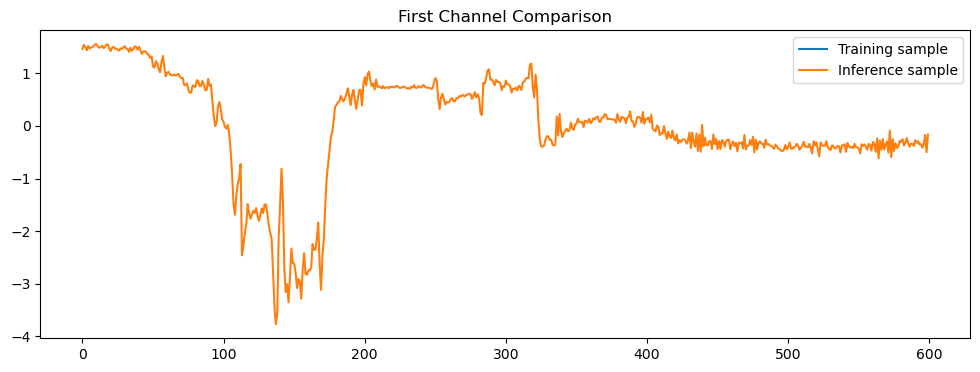

Input shape: torch.Size([1, 1, 8, 600])
IMU data shape: torch.Size([1, 8, 600])
Sample IMU values (first channel): tensor([1.4624, 1.5423, 1.5033, 1.4399, 1.5186, 1.4720, 1.4915, 1.5007, 1.5192,
        1.5508], device='mps:0')
large scale features shape: torch.Size([1, 32, 75])
medium scale features shape: torch.Size([1, 32, 75])
small scale features shape: torch.Size([1, 32, 75])
Combined features shape: torch.Size([1, 96, 75])
Temporal features shape: torch.Size([1, 64, 75])
Temporal mean shape: torch.Size([1, 64])
PSD features shape: torch.Size([1, 8, 5])
PSD mean shape: torch.Size([1, 5])
PSD processed shape: torch.Size([1, 16])
Combined features shape: torch.Size([1, 80])
Attention weights shape: torch.Size([1, 1])
Weighted features shape: torch.Size([1, 64])
Input shape: torch.Size([1, 1, 8, 600])
IMU data shape: torch.Size([1, 8, 600])
Sample IMU values (first channel): tensor([1.4624, 1.5423, 1.5033, 1.4399, 1.5186, 1.4720, 1.4915, 1.5007, 1.5192,
        1.5508], device='mps:

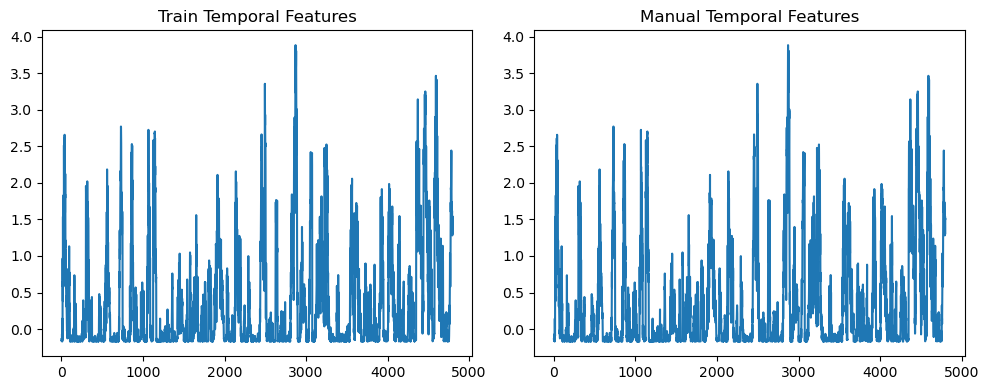

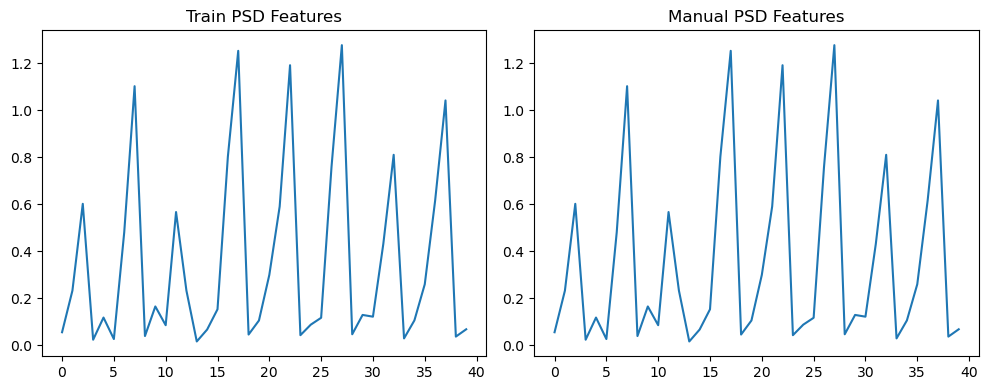


=== Prediction Comparison ===
Train prediction probs: [2.8347864e-07 2.7889894e-06 1.4610528e-07 8.9132409e-06 1.7429224e-05
 2.3706161e-05 1.6747549e-04 4.3964152e-05 6.1787308e-05 4.7517827e-01
 1.3617606e-02 2.1966273e-06 1.2562618e-06 4.1921192e-04 5.8658738e-03
 3.3464380e-02 1.5417208e-06 9.0970079e-06 4.4278763e-03 3.2477041e-03
 4.6034667e-01 1.7634270e-03 1.0426614e-04 1.1379667e-07 5.1393999e-07
 3.5712892e-05 9.4714969e-06 1.1782575e-03]
Manual prediction probs: [2.8347864e-07 2.7889894e-06 1.4610528e-07 8.9132409e-06 1.7429224e-05
 2.3706161e-05 1.6747549e-04 4.3964152e-05 6.1787308e-05 4.7517827e-01
 1.3617606e-02 2.1966273e-06 1.2562618e-06 4.1921192e-04 5.8658738e-03
 3.3464380e-02 1.5417208e-06 9.0970079e-06 4.4278763e-03 3.2477041e-03
 4.6034667e-01 1.7634270e-03 1.0426614e-04 1.1379667e-07 5.1393999e-07
 3.5712892e-05 9.4714969e-06 1.1782575e-03]

=== Feature Differences ===
Temporal features mean difference: 0.0
PSD features mean difference: 0.0

=== Attention Weigh

In [16]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
from pathlib import Path

# Device setup
device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()
    else torch.device("cpu")
)

# Load label mappings
with open(f"{DATAFILES_DIR}/label_map.json", 'r') as f:
    label_dict = json.load(f)

# Move model to device
model = model.to(device)

# Reverse label dict
id_to_label_name = {v: k for k, v in label_dict.items()}
index_to_label_id = {i: lid for i, lid in enumerate(sorted(label_dict.values()))}
label_id_to_index = {lid: i for i, lid in index_to_label_id.items()}

# Load and process single CSV
csv_path = "../../frontend/handgestures/apps/main_app/static/main_app/data/tonic/standing/Josh59.csv"

# Find matching training sample
index = -1
for idx, item in enumerate(train_dataset.samples):
    if csv_path.split('/')[-1] in item['path']: 
        index = idx
        break

if index == -1:
    raise ValueError("Could not find matching training sample for verification")

print(f"\nFound matching training sample at index: {index}")

batch_size = train_loader.batch_size
dataset_idx = index // 8  # Example: Find where this index lands in the loader

j = dataset_idx // batch_size
i = dataset_idx % batch_size

# Get the j-th batch (only works if shuffle=False)
for batch_j, (x_batch, y_batch) in enumerate(train_loader):
    if batch_j == j:
        print(f"Dataset index {dataset_idx} is in:")
        print(f"- Batch {j}, position {i}")
        print(f"- Data shape: {x_batch[i].shape}")
        train_sample = x_batch[i]
        train_label = y_batch[i]
        print(f"- Label: {y_batch[i]}")
        break
else:
    print("Batch not found (shuffle=True?)")

# Verification 2: Test with actual training data
print("\n=== Training Sample Verification ===")
# train_sample, train_label = next(iter(train_loader))
train_sample = train_sample.unsqueeze(0).to(device)
train_label = train_label.to(device)

with torch.no_grad():
    model.eval()
    # Run standard forward
    output = model(train_sample)
    predicted_label = torch.argmax(output, 1).item()
    
    # Run debug forward
    debug_output = model.debug_forward(train_sample, verbose=True)
    
    print(f"\nTraining sample prediction: {predicted_label} (should be {train_label.item()})")
    print(f"Input device: {train_sample.device}, Model device: {next(model.parameters()).device}")

# Process the matching file
x1, y1 = train_dataset[index]  # training sample
x1 = x1.unsqueeze(0).to(device)  # Add batch dim and move to device (shape: [1, time_steps, channels, seq_len])

inference = ProcessSingleRawOnly(sample_data=train_dataset.samples[index], device=device)
x2, y2 = inference.process_single_csv()  # inference processing
x2 = x2.to(device)

# Verification 3: Visual comparison
print("\n=== Input Data Verification ===")
print("Train sample shape:", x1.shape)
print("Inference sample shape:", x2.shape)
print(f"Train device: {x1.device}, Inference device: {x2.device}")
diff = (x1 - x2).abs().mean()
print(f"Difference: {diff.item()}")

# Plot first channel comparison - FIXED version
plt.figure(figsize=(12, 4))

# For x1 (training sample) - shape [1, time_steps, channels, seq_len]
plt.plot(x1[0, -1, 0].cpu().numpy(), label='Training sample')  # Last time step, first channel

# For x2 - need to check shape and adjust indexing
if len(x2.shape) == 4:  # Same as x1 [batch, time_steps, channels, seq_len]
    plt.plot(x2[0, -1, 0].cpu().numpy(), label='Inference sample')
elif len(x2.shape) == 3:  # Possibly [batch, channels, seq_len]
    plt.plot(x2[0, 0].cpu().numpy(), label='Inference sample')
elif len(x2.shape) == 2:  # Possibly [channels, seq_len]
    plt.plot(x2[0].cpu().numpy(), label='Inference sample')
else:
    raise ValueError(f"Unexpected input shape for x2: {x2.shape}")

plt.title("First Channel Comparison")
plt.legend()
plt.show()

# Run debug forward on both samples
with torch.no_grad():
    model.eval()
    train_debug = model.debug_forward(x1, verbose=True)
    manual_debug = model.debug_forward(x2, verbose=True)

# Feature comparison plots
def plot_feature_comparison(train_feat, manual_feat, title):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_feat[0].cpu().numpy().flatten(), label='Train')
    plt.title(f"Train {title}")
    plt.subplot(1, 2, 2)
    plt.plot(manual_feat[0].cpu().numpy().flatten(), label='Manual')
    plt.title(f"Manual {title}")
    plt.tight_layout()
    plt.show()

print("\n=== Feature Comparisons ===")
plot_feature_comparison(train_debug['temporal_features'], 
                      manual_debug['temporal_features'],
                      "Temporal Features")

plot_feature_comparison(train_debug['psd_features'], 
                      manual_debug['psd_features'],
                      "PSD Features")

# Compare predictions
def compare_predictions(train_output, manual_output):
    train_pred = F.softmax(train_output['logits'], dim=1)
    manual_pred = F.softmax(manual_output['logits'], dim=1)
    
    print("\n=== Prediction Comparison ===")
    print(f"Train prediction probs: {train_pred[0].cpu().numpy()}")
    print(f"Manual prediction probs: {manual_pred[0].cpu().numpy()}")
    
    print("\n=== Feature Differences ===")
    print("Temporal features mean difference:", 
          (train_output['temporal_features'].mean() - manual_output['temporal_features'].mean()).item())
    print("PSD features mean difference:", 
          (train_output['psd_features'].mean() - manual_output['psd_features'].mean()).item())
    
    print("\n=== Attention Weights ===")
    print("Train attention:", train_output['attention_weights'][0].item())
    print("Manual attention:", manual_output['attention_weights'][0].item())

compare_predictions(train_debug, manual_debug)

# Run inference
print("\n=== Running Inference ===")
result = inference.predict_from_csv(
    train_dataset.samples[index]['path'], 
    model, 
    label_dict, 
    index_to_label_id, 
    label_id_to_index, 
    id_to_label_name
)

# Print results
print("\n=== Results ===")
print(f"Predicted Label: {result['predicted_label']} (index {result['predicted_index']}, id {result['predicted_label_id']})")
print(f"True Label:     {result['true_label']} (index {result['true_index']}, id {result['true_label_id']})")

print("\nTop Predictions:")
for i, (label, prob) in enumerate(sorted(
    [(k, v) for k, v in result['probabilities'].items()], 
    key=lambda x: -x[1]
)[:5]):
    print(f"{i+1}. {label:20s}: {prob:.4f}")

print("\n=== Label Mappings ===")
print(f"All index_to_label_id keys: {list(index_to_label_id.keys())}")
print(f"All label IDs in id_to_label_name: {list(id_to_label_name.keys())}")
print(f"All label names in label_dict: {list(label_dict.keys())}")

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from pathlib import Path

# Device setup
device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()
    else torch.device("cpu")
)

# Load label mappings
with open(f"{DATAFILES_DIR}/label_map.json", 'r') as f:
    label_dict = json.load(f)

# Move model to device
model = model.to(device)

# Verification 1: Check model weights
print("\n=== Model Verification ===")
print("Model first conv weight mean:", model.feature_extractor['large'][0].weight.mean().item())
print(f"Model device: {next(model.parameters()).device}")

# Reverse label dict
id_to_label_name = {v: k for k, v in label_dict.items()}
index_to_label_id = {i: lid for i, lid in enumerate(sorted(label_dict.values()))}
label_id_to_index = {lid: i for i, lid in index_to_label_id.items()}

# Load and process single CSV
csv_path = "../../frontend/handgestures/apps/main_app/static/main_app/data/tonic/standing/Josh59.csv"

# Find matching training sample
index = -1
for idx, item in enumerate(train_dataset.samples):
    if csv_path.split('/')[-1] in item['path']: 
        index = idx
        break

if index == -1:
    raise ValueError("Could not find matching training sample for verification")

print(f"\nFound matching training sample at index: {index}")

# Verification 2: Test with actual training data
print("\n=== Training Sample Verification ===")
train_sample, train_label = next(iter(train_loader))
train_sample = train_sample.to(device)  # Move to same device as model
train_label = train_label.to(device)

with torch.no_grad():
    model.eval()
    output = model(train_sample[:1])  # Test on first training sample
    predicted_label = torch.argmax(output, 1).item()
    print(f"Training sample prediction: {predicted_label} (should be {train_label[0].item()})")
    print(f"Input device: {train_sample.device}, Model device: {next(model.parameters()).device}")

# Process the matching file
x1, y1 = train_dataset[index]  # training sample
x1 = x1.to(device)  # Move to device

inference = ProcessSingleRawOnly(sample_data=train_dataset.samples[index] ,device=device)  # Pass device to ensure consistency
x2, _ = inference.process_single_csv()  # inference processing (already on device)
x2 = x2.to(device)

# Verification 3: Visual comparison
print("\n=== Input Data Verification ===")
print("Train sample shape:", x1.shape)
print("Inference sample shape:", x2.shape)
print(f"Train device: {x1.device}, Inference device: {x2.device}")
diff = (x1 - x2.squeeze(0)).abs().mean()
print(f"Difference: {diff.item()}")

# # Plot first channel comparison
# plt.figure(figsize=(12, 4))
# plt.plot(x1[0].cpu().numpy(), label='Training sample')
# plt.plot(x2.squeeze(0)[0].cpu().numpy(), label='Inference sample')
# plt.title("First Channel Comparison")
# plt.legend()
# plt.show()

# Run inference
print("\n=== Running Inference ===")
result = inference.predict_from_csv(
    train_dataset.samples[index]['path'], 
    model, 
    label_dict, 
    index_to_label_id, 
    label_id_to_index, 
    id_to_label_name
)

# Print results
print("\n=== Results ===")
print(f"Predicted Label: {result['predicted_label']} (index {result['predicted_index']}, id {result['predicted_label_id']})")
print(f"True Label:     {result['true_label']} (index {result['true_index']}, id {result['true_label_id']})")

print("\nTop Predictions:")
for i, (label, prob) in enumerate(sorted(
    [(k, v) for k, v in result['probabilities'].items()], 
    key=lambda x: -x[1]
)[:5]):
    print(f"{i+1}. {label:20s}: {prob:.4f}")

print("\n=== Label Mappings ===")
print(f"All index_to_label_id keys: {list(index_to_label_id.keys())}")
print(f"All label IDs in id_to_label_name: {list(id_to_label_name.keys())}")
print(f"All label names in label_dict: {list(label_dict.keys())}")

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os

# # Load the saved dictionary
# data = torch.load(f"{DATAFILES_DIR}/raw_psd_handgestures_dataset.pt", map_location="cpu", weights_only=False)
# label_dict = data["label_dict"]
with open(f"{DATAFILES_DIR}/label_map.json", 'r') as f:
    label_dict = json.load(f)

# Device setup
device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()
    else torch.device("cpu")
)

# Check if model is loading weights correctly
print("Model first conv weight mean:", model.feature_extractor['large'][0].weight.mean())

# Reverse label dict
id_to_label_name = {v: k for k, v in label_dict.items()}
index_to_label_id = {i: lid for i, lid in enumerate(sorted(label_dict.values()))}
label_id_to_index = {lid: i for i, lid in index_to_label_id.items()}

print("label_dict:", label_dict)
print("index_to_label_id:", index_to_label_id)
print("id_to_label_name:", id_to_label_name)


# Load and process single CSV
csv_path = "../../frontend/handgestures/apps/main_app/static/main_app/data/tonic/standing/Josh59.csv"
# raw_tensor, psd_tensor = process_single_csv_raw_psd(csv_path)  # raw: (1, 8, 8, 600), psd: (1, 5)
inference = ProcessSingleRawOnly()
# result = inference.predict_from_csv(
#     csv_path, model, label_dict, index_to_label_id, label_id_to_index, id_to_label_name
# )

# print(result)

# Find the match in the training data for the inference file
index = -1;
for idx, item in enumerate(train_dataset.samples):
    if csv_path.split('/')[-1] in item['path']: index = idx

print(f'This is the index of the sample in the training data: {index}')
print(train_dataset[index])
print(train_dataset.samples[index])

# Pick same training file
x1, _ = train_dataset[index]  # training
x2 = inference.process_single_csv(train_dataset.samples[index]['path'])  # inference

result = inference.predict_from_csv(
    train_dataset.samples[index]['path'], model, label_dict, index_to_label_id, label_id_to_index, id_to_label_name
)

print("Train sample shape:", x1.shape)
print("Inference sample shape:", x2.shape)
print("Difference:", (x1.to(device) - x2.squeeze(0).to(device)).abs().mean())

# # Send to device
# raw_tensor = raw_tensor.to(device).float()  # (1, 8, 8, 600)
# psd_tensor = psd_tensor.to(device).float()  # (1, 5)

# # Infer true label from path
# label_folder = os.path.basename(os.path.dirname(csv_path)).lower()
# label_name = label_folder.split("_")[0]
# true_label_id = label_dict.get(label_name, None)
# true_idx = label_id_to_index.get(true_label_id, -1)
# true_label_name = label_name if true_label_id is not None else "UNKNOWN"

# # Run inference
# model.to(device)
# model.eval()
# with torch.no_grad():
#     outputs = model(raw_tensor, psd_tensor)  # Adjust if your model takes inputs as a tuple/list
#     probs = F.softmax(outputs, dim=1)
#     pred = torch.argmax(probs, dim=1)

# # Decode prediction
# pred_idx = pred.item()
# pred_label_id = index_to_label_id.get(pred_idx, None)
# pred_label_name = id_to_label_name.get(pred_label_id, "UNKNOWN")

print("Single Sample Inference Result:")
print(f"Predicted Label: {result['predicted_label']} (index {result['predicted_index']}, id {result['predicted_label_id']})")
print(f"True Label:     {result['true_label']} (index {result['true_index']}, id {result['true_label_id']})")

print("\nPer-Class Probabilities:")
for label_name, prob in result['probabilities'].items():
    label_name = f"ID_{label_name}"
    print(f"{label_name:15s}: {prob:.4f}")

print(f"All index_to_label_id keys: {list(index_to_label_id.keys())}")
print(f"All label IDs in id_to_label_name: {list(id_to_label_name.keys())}")
print(f"All label names in label_dict: {list(label_dict.keys())}")

# # Original access still works
# print(result["predicted_label"])
# print(result["probabilities"])

# New diagnostics available
# print("Input stats:", result["input_verification"])

# for idx in range(num_classes):
#     lid = index_to_label_id.get(idx)
#     lname = id_to_label_name.get(lid, "UNKNOWN")
#     print(f"Index {idx} -> Label ID {lid} -> Label Name {lname}")


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import random
import pandas as pd
import os

# Load the saved dictionary
data = torch.load(f"{DATAFILES_DIR}/cwt_handgestures_6channels_dataset.pt", map_location="cpu", weights_only=False)
label_dict = data["label_dict"]

# Device setup
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Reverse label dict
id_to_label_name = {v: k for k, v in label_dict.items()}
index_to_label_id = {i: lid for i, lid in enumerate(sorted(label_dict.values()))}
label_id_to_index = {lid: i for i, lid in index_to_label_id.items()}

# Load and process single CSV
csv_path = "../../frontend/handgestures/apps/main_app/static/main_app/data/Josh59.csv"
cwt_tensor = process_single_csv_cwt(csv_path)  # shape: (1, 127, 127, 6)

# Prepare input tensor
x_single = torch.from_numpy(cwt_tensor).permute(0, 3, 1, 2).float().to(device)  # (1, 6, 127, 127)
x_single = x_single.unsqueeze(1)  # reshape to (1, 1, 6, 127, 127)

# Infer true label from path
label_folder = os.path.basename(os.path.dirname(csv_path)).lower()
label_name = label_folder.split("_")[0]  # Strip variants like '_variant'
true_label_id = label_dict.get(label_name, None)
true_idx = label_id_to_index.get(true_label_id, -1)
true_label_name = label_name if true_label_id is not None else "UNKNOWN"

# Run inference
model.to(device)
model.eval()
with torch.no_grad():
    outputs = model(x_single)
    probs = F.softmax(outputs, dim=1)
    pred = torch.argmax(probs, dim=1)

# Decode prediction
pred_idx = pred.item()
pred_label_id = index_to_label_id.get(pred_idx, None)
pred_label_name = id_to_label_name.get(pred_label_id, "UNKNOWN")

print("Single Sample Inference Result:")
print(f"Predicted Label: {pred_label_name} (index {pred_idx}, id {pred_label_id})")
print(f"True Label:     {true_label_name} (index {true_idx}, id {true_label_id})")

print("\nPer-Class Probabilities:")
for i, p in enumerate(probs[0].cpu().numpy()):
    label_id = index_to_label_id[i]
    label_name = id_to_label_name.get(label_id, f"ID_{label_id}")
    print(f"{label_name:15s}: {p:.4f}")


In [ ]:
import torch.nn.functional as F

# Create reverse dict for id -> name
id_to_label_name = {v: k for k, v in label_dict.items()}

# Device setup
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Load dataset
cwt_data = torch.load(f"{DATAFILES_DIR}/cwt_handgestures_6channels_dataset.pt", map_location="cpu", weights_only=False)
x_test = cwt_data["x_test"]
y_test = cwt_data["y_test"]

unique_label_ids = sorted(set(y_test))
index_to_label_id = {idx: label_id for idx, label_id in enumerate(unique_label_ids)}
label_id_to_index = {label_id: idx for idx, label_id in enumerate(unique_label_ids)}
y_test_idx = np.array([label_id_to_index[y] for y in y_test])

perm = np.random.permutation(len(y_test_idx))
x_test = x_test[perm]
y_test_idx = y_test_idx[perm]

x_test_tensor = x_test.permute(0, 3, 1, 2).float()

time_steps = 8
def pad_to_multiple(tensor, multiple, dim=0, pad_value=0):
    length = tensor.size(dim)
    remainder = length % multiple
    if remainder == 0:
        return tensor
    pad_len = multiple - remainder
    pad_shape = list(tensor.shape)
    pad_shape[dim] = pad_len
    pad_tensor = torch.full(pad_shape, pad_value, dtype=tensor.dtype)
    return torch.cat([tensor, pad_tensor], dim=dim)

x_test_tensor = pad_to_multiple(x_test_tensor, time_steps, dim=0)
y_test_idx = np.pad(y_test_idx, (0, x_test_tensor.size(0) - len(y_test_idx)), constant_values=-100)
y_test_tensor = torch.tensor(y_test_idx, dtype=torch.long)

num_batches = x_test_tensor.size(0) // time_steps
x_test_seq = x_test_tensor.view(num_batches, time_steps, 6, 127, 127)
y_test_seq = y_test_tensor.view(num_batches, time_steps)[:, -1]

model.to(device)
model.eval()

sample_idx = random.randint(0, x_test_seq.size(0) - 1)
x_single = x_test_seq[sample_idx:sample_idx+1].to(device)
y_single = y_test_seq[sample_idx:sample_idx+1]

with torch.no_grad():
    outputs = model(x_single)  # logits
    probs = F.softmax(outputs, dim=1)  # probabilities over classes
    pred = torch.argmax(probs, dim=1)

pred_idx = pred.item()
true_idx = y_single.item()
pred_label_id = index_to_label_id.get(pred_idx, None)
true_label_id = index_to_label_id.get(true_idx, None)
pred_label_name = id_to_label_name.get(pred_label_id, "UNKNOWN")
true_label_name = id_to_label_name.get(true_label_id, "UNKNOWN")

print("Single Sample Inference Result:")
print(f"Predicted Label: {pred_label_name} (index {pred_idx}, id {pred_label_id})")
print(f"True Label: {true_label_name} (index {true_idx}, id {true_label_id})")

print("\nPer-Class Probabilities:")
for i, p in enumerate(probs[0].cpu().numpy()):
    label_id = index_to_label_id[i]
    label_name = id_to_label_name.get(label_id, f"ID_{label_id}")
    print(f"{label_name:15s}: {p:.4f}")


## Preprocess HandGesture Dataset

This will run the preprocessing on the individual CSV files that were collected from the
sensor hardware device

In [ ]:
label_map_collapse_4_classifiers = {
    # Tremor (exclude running/falling)
    'tremor_walking': 'tremor',
    'tremor_standing': 'tremor',
    'tremor_sitting': 'tremor',
    'tremor_laying': 'tremor',
    'tremor_stairs': 'tremor',
    'tremor_running': 'tremor',
    'tremor_falling': 'tremor',
    # Postural
    'postural_walking': 'postural',
    'postural_standing': 'postural',
    'postural_sitting': 'postural',
    'postural_laying': 'postural',
    'postural_stairs': 'postural',
    'postural_running': 'postural',
    'postural_falling': 'postural',
    # Normal
    'normal_walking': 'normal',
    'normal_standing': 'normal',
    'normal_sitting': 'normal',
    'normal_laying': 'normal',
    'normal_stairs': 'normal',
    'normal_running': 'normal',
    'normal_falling': 'normal',
    # Tonic
    'tonic_walking': 'tonic',
    'tonic_standing': 'tonic',
    'tonic_sitting': 'tonic',
    'tonic_laying': 'tonic',
    'tonic_stairs': 'tonic',
    'tonic_running': 'tonic',
    'tonic_falling': 'tonic',
}

## Load the data from preprocessing

This will allow us to reload the data if we have already completed the preprocessing step.

In [ ]:
# Load the saved dictionary
data = torch.load(f"{DATAFILES_DIR}/cwt_handgestures_6channels_dataset.pt", map_location="cpu", weights_only=False)  # or 'device' if using GPU/MPS

# Unpack the contents into variables
x_train = data["x_train"]
y_train = data["y_train"]
x_test = data["x_test"]
y_test = data["y_test"]
label_dict = data["label_dict"]

In [ ]:
# Load the dataset
data = torch.load(f"{DATAFILES_DIR}/psd_handgestures_6channels_dataset.pt", weights_only=False)

# Extract variables
psd_train = data["psd_train"]
train_labels = data["train_labels"]
psd_test = data["psd_test"]
test_labels = data["test_labels"]
label_dict = data["label_dict"]

## Visualize preprocessed data

This will let us make sure that we have loaded the data properly, by looking at the data in the file and visualizing it.

In [ ]:
# Choose a random sample index
sample_index = random.randint(0, x_train.shape[0] - 1)

# Plot the CWT images for all channels in that sample
plt.figure(figsize=(12, 6))
for ch in range(x_train.shape[3]):  # Automatically use available channels
    plt.subplot(2, 4, ch + 1)
    plt.imshow(x_train[sample_index, :, :, ch], cmap='viridis')
    plt.title(f'Channel {ch}')
    plt.axis('off')
plt.suptitle(f'CWT for Sample {sample_index}')
plt.tight_layout()
plt.show()

# Machine Learning

This will use Pytorch to do training on the dataset pre-processed into sonographs. This is memory-optimized to ensure that MPS does
not have problems with memory leaking, and ensure that we can maintain a large enough batch size.

If MPS is possible, then that device feature will be used. This will offload much of the training to the graphics cores, but some of
The main processor will still be used for training, especially in the beginning. This is a memory-intensive task, and expect the memory pressure at first to be near 50GB, but it does reduce down to approximately 20GB after dataloading. This will be intensive on any machine that does not have 32GB of memory.

This training will run for ten epochs, to ensure that we can reach a high enough accuracy with the test dataset (validation data)

In [ ]:
# Model definition
class CNNLSTM(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(CNNLSTM, self).__init__()
        input_shape = (127, 127, 6)
        self.cnn = nn.Sequential(
            nn.Conv2d(input_channels, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 63x63

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 31x31

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 15x15
        )
        # Infer CNN output size dynamically
        dummy_input = torch.zeros(1, input_channels, input_shape[0], input_shape[1])
        cnn_output_dim = self.cnn(dummy_input).view(1, -1).size(1)

        self.lstm = nn.LSTM(input_size=cnn_output_dim, hidden_size=128,
                            batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(128 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x shape: (B, T, C, H, W)
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)  # combine batch and time for CNN
        x = self.cnn(x)
        x = x.view(B, T, -1)  # separate batch and time
        out, _ = self.lstm(x)
        # Use output of last timestep
        return self.classifier(out[:, -1, :])

In [ ]:
# New version of ML Model with CNN based on CWT Sonograms, and LSTM for temporal analysis

# Memory Configuration (must come first)
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'
os.environ['PYTORCH_MPS_MAX_CACHE_SIZE'] = '0'

# Memory monitoring function
def print_memory_stats(prefix=""):
    if torch.backends.mps.is_available():
        allocated = torch.mps.current_allocated_memory() / 1e9
        reserved = torch.mps.driver_allocated_memory() / 1e9
        print(f"{prefix} Memory: Alloc={allocated:.2f}GB, Reserved={reserved:.2f}GB")

# Device and seed setup
torch.manual_seed(42)
np.random.seed(42)
# Device setup (check hardware in platform)
if torch.backends.mps.is_available(): device = torch.device("mps")
elif torch.cuda.is_available(): device = torch.device("cuda")
else: device = torch.device("cpu")
    
# Better randomization and memory allocation
if torch.backends.mps.is_available():
    torch.mps.manual_seed(42)
    torch.mps.set_per_process_memory_fraction(1.0)
elif torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.set_per_process_memory_fraction(1.0)

print(f"Using device: {device}")
print_memory_stats("Initial")

# Parameters
input_shape = (127, 127, 6)
batch_size = 16
num_classes = len(label_dict)
epochs = 10
accumulation_steps = 2
time_steps = 8  # number of temporal slices per sample

# Assume x_train, x_test, y_train, y_test are defined elsewhere
# For example, x_train shape: (N, 127, 127, 6)
# y_train shape: (N,)
# Make sure data is torch tensor or numpy array accordingly

# Mapping labels to indices
y_all = np.concatenate([y_train, y_test])
index_to_label = {label: idx for idx, label in enumerate(sorted(set(y_all)))}
y_train_indices = np.array([index_to_label[label.item()] if hasattr(label, 'item') else index_to_label[label] for label in y_train])
y_test_indices = np.array([index_to_label[label.item()] if hasattr(label, 'item') else index_to_label[label] for label in y_test])

def normalize(tensor):
    mean = tensor.mean(dim=(2, 3), keepdim=True)
    std = tensor.std(dim=(2, 3), keepdim=True) + 1e-6
    return (tensor - mean) / std

# x_train_tensor = normalize(torch.tensor(x_train).float().permute(0, 3, 1, 2))  # (N, C, H, W)
# x_test_tensor = normalize(torch.tensor(x_test).float().permute(0, 3, 1, 2))
x_train_tensor = normalize(x_train.detach().clone().float().permute(0, 3, 1, 2))
x_test_tensor = normalize(x_test.detach().clone().float().permute(0, 3, 1, 2))
y_train_tensor = torch.tensor(y_train_indices, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_indices, dtype=torch.long)

def pad_to_multiple(tensor, multiple, dim=0, pad_value=0):
    """
    Pads tensor along dimension `dim` to a size that is a multiple of `multiple`.
    """
    size = tensor.size(dim)
    remainder = size % multiple
    if remainder == 0:
        return tensor  # no padding needed
    padding_size = multiple - remainder
    pad_shape = list(tensor.shape)
    pad_shape[dim] = padding_size
    pad_tensor = torch.full(pad_shape, pad_value, dtype=tensor.dtype, device=tensor.device)
    return torch.cat([tensor, pad_tensor], dim=dim)

# Pad datasets so total samples are divisible by time_steps
x_train_tensor = pad_to_multiple(x_train_tensor, time_steps, dim=0, pad_value=0)
x_test_tensor = pad_to_multiple(x_test_tensor, time_steps, dim=0, pad_value=0)
y_train_tensor = pad_to_multiple(y_train_tensor, time_steps, dim=0, pad_value=-100)  # Use ignore_index -100 for padding labels
y_test_tensor = pad_to_multiple(y_test_tensor, time_steps, dim=0, pad_value=-100)

# Reshape to (batch, time_steps, channels, H, W)
num_train_batches = x_train_tensor.size(0) // time_steps
num_test_batches = x_test_tensor.size(0) // time_steps

x_train_seq = x_train_tensor.view(num_train_batches, time_steps, *input_shape[::-1])  # input_shape[::-1] flips (H,W,C) -> (C,H,W)
y_train_seq = y_train_tensor.view(num_train_batches, time_steps)

x_test_seq = x_test_tensor.view(num_test_batches, time_steps, *input_shape[::-1])
y_test_seq = y_test_tensor.view(num_test_batches, time_steps)

# We only use the label of the last timestep for training/classification
y_train_seq_last = y_train_seq[:, -1]
y_test_seq_last = y_test_seq[:, -1]

model = CNNLSTM(input_channels=6, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-100)  # ignore padded labels in loss
optimizer = Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(TensorDataset(x_train_seq, y_train_seq_last), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test_seq, y_test_seq_last), batch_size=batch_size)

history = defaultdict(list)
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    train_loss, correct, total = 0.0, 0, 0
    epoch_start = time()

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels) / accumulation_steps
        loss.backward()

        if (batch_idx + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

        train_loss += loss.item() * accumulation_steps
        _, predicted = torch.max(outputs.data, 1)
        mask = labels != -100  # only count non-padded labels
        correct += (predicted[mask] == labels[mask]).sum().item()
        total += mask.sum().item()

        if batch_idx % 10 == 0:
            if torch.backends.mps.is_available(): torch.mps.empty_cache()
            if torch.cuda.is_available(): torch.cuda.empty_cache()
            gc.collect()

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            mask = labels != -100
            val_correct += (predicted[mask] == labels[mask]).sum().item()
            val_total += mask.sum().item()
            if batch_idx % 10 == 0:
                if torch.backends.mps.is_available(): torch.mps.empty_cache()
                elif torch.cuda.is_available(): torch.cuda.empty_cache()
                gc.collect()

    history['train_loss'].append(train_loss / len(train_loader))
    history['train_acc'].append(correct / total if total > 0 else 0)
    history['val_loss'].append(val_loss / len(test_loader))
    history['val_acc'].append(val_correct / val_total if val_total > 0 else 0)

    print(f"Epoch {epoch + 1}/{epochs} - {time() - epoch_start:.1f}s")
    print(f"Train Loss: {history['train_loss'][-1]:.4f} Acc: {history['train_acc'][-1]:.4f}")
    print(f"Val Loss: {history['val_loss'][-1]:.4f} Acc: {history['val_acc'][-1]:.4f}")
    print_memory_stats("Epoch End")
    print()
    
    if torch.backends.mps.is_available(): torch.mps.empty_cache()
    elif torch.cuda.is_available(): torch.cuda.empty_cache()
    gc.collect()
    print()

def safe_evaluate(model, inputs, labels, chunk_size=8):
    model.eval()
    total_loss, correct = 0.0, 0
    with torch.no_grad():
        for i in range(0, inputs.size(0), chunk_size):
            chunk_inputs = inputs[i:i + chunk_size].to(device)
            chunk_labels = labels[i:i + chunk_size].to(device)

            outputs = model(chunk_inputs)
            total_loss += criterion(outputs, chunk_labels).item() * chunk_inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            mask = chunk_labels != -100
            correct += (predicted[mask] == chunk_labels[mask]).sum().item()
            # SAFE cleanup
            del chunk_inputs, chunk_labels, outputs, predicted, mask
            if i % 10 == 0:
                if torch.backends.mps.is_available(): torch.mps.empty_cache()
                elif torch.cuda.is_available(): torch.cuda.empty_cache()
                gc.collect()

    return total_loss / inputs.size(0), correct / inputs.size(0)

train_loss, train_acc = safe_evaluate(model, x_train_seq, y_train_seq_last)
test_loss, test_acc = safe_evaluate(model, x_test_seq, y_test_seq_last)

print('Final Results:')
print(f'Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}')
print(f'Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}')
print_memory_stats("Final")

## Save Model

Save the trained model for later use

In [ ]:
# Save the model
torch.save(model.state_dict(), f"{MODELFILES_DIR}/handgestures_trained_6-channel_CNN-LSTM_model_weights_99percent.pt")

# Save the history (loss and accuracy)
df_history = pd.DataFrame(history)
df_history.to_csv(f"{MODELFILES_DIR}/handgestures_6-channel_CNN-LSTM_training_history_99percent.csv", index=False)

## Inspect Size and Shape

We will inspect the size and shape of the data and tensors, so that we can determine what kind of samples we have to train

In [ ]:
print("x_train shape:", x_train.shape)
print("x_train_tensor shape:", x_train_tensor.shape)
print("x_train_tensor stats: mean =", x_train_tensor.mean().item(), "std =", x_train_tensor.std().item())
print("Sample input min/max:", x_train_tensor[0].min().item(), x_train_tensor[0].max().item())

# Validations
---

This will validate that the trained data can properly validate the test data set after training

In [ ]:
# Device setup (check hardware in platform)
if torch.backends.mps.is_available(): device = torch.device("mps")
elif torch.cuda.is_available(): device = torch.device("cuda")
else: device = torch.device("cpu")

model = CNNLSTM(input_channels=6, num_classes=len(label_dict)).to(device)

# 3. Load the saved weights
model.load_state_dict(
    torch.load(f"{MODELFILES_DIR}/handgestures_trained_6-channel_CNN-LSTM_model_weights_99percent.pt",
               map_location=device,
               weights_only=False))

# model.eval()  # Set to evaluation mode

## Random Prediction

Pick a random sample from the HandGestures wavelets and do a prediction

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import random
import pandas as pd
import os

# Load the saved dictionary
data = torch.load(f"{DATAFILES_DIR}/cwt_handgestures_6channels_dataset.pt", map_location="cpu", weights_only=False)
label_dict = data["label_dict"]

# Device setup
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Reverse label dict
id_to_label_name = {v: k for k, v in label_dict.items()}
index_to_label_id = {i: lid for i, lid in enumerate(sorted(label_dict.values()))}
label_id_to_index = {lid: i for i, lid in index_to_label_id.items()}

# Load and process single CSV
csv_path = "../../frontend/handgestures/apps/main_app/static/main_app/data/Josh59.csv"
cwt_tensor = process_single_csv_cwt(csv_path)  # shape: (1, 127, 127, 6)

# Prepare input tensor
x_single = torch.from_numpy(cwt_tensor).permute(0, 3, 1, 2).float().to(device)  # (1, 6, 127, 127)
x_single = x_single.unsqueeze(1)  # reshape to (1, 1, 6, 127, 127)

# Infer true label from path
label_folder = os.path.basename(os.path.dirname(csv_path)).lower()
label_name = label_folder.split("_")[0]  # Strip variants like '_variant'
true_label_id = label_dict.get(label_name, None)
true_idx = label_id_to_index.get(true_label_id, -1)
true_label_name = label_name if true_label_id is not None else "UNKNOWN"

# Run inference
model.to(device)
model.eval()
with torch.no_grad():
    outputs = model(x_single)
    probs = F.softmax(outputs, dim=1)
    pred = torch.argmax(probs, dim=1)

# Decode prediction
pred_idx = pred.item()
pred_label_id = index_to_label_id.get(pred_idx, None)
pred_label_name = id_to_label_name.get(pred_label_id, "UNKNOWN")

print("Single Sample Inference Result:")
print(f"Predicted Label: {pred_label_name} (index {pred_idx}, id {pred_label_id})")
print(f"True Label:     {true_label_name} (index {true_idx}, id {true_label_id})")

print("\nPer-Class Probabilities:")
for i, p in enumerate(probs[0].cpu().numpy()):
    label_id = index_to_label_id[i]
    label_name = id_to_label_name.get(label_id, f"ID_{label_id}")
    print(f"{label_name:15s}: {p:.4f}")


In [ ]:
import torch.nn.functional as F

# Create reverse dict for id -> name
id_to_label_name = {v: k for k, v in label_dict.items()}

# Device setup
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Load dataset
cwt_data = torch.load(f"{DATAFILES_DIR}/cwt_handgestures_6channels_dataset.pt", map_location="cpu", weights_only=False)
x_test = cwt_data["x_test"]
y_test = cwt_data["y_test"]

unique_label_ids = sorted(set(y_test))
index_to_label_id = {idx: label_id for idx, label_id in enumerate(unique_label_ids)}
label_id_to_index = {label_id: idx for idx, label_id in enumerate(unique_label_ids)}
y_test_idx = np.array([label_id_to_index[y] for y in y_test])

perm = np.random.permutation(len(y_test_idx))
x_test = x_test[perm]
y_test_idx = y_test_idx[perm]

x_test_tensor = x_test.permute(0, 3, 1, 2).float()

time_steps = 8
def pad_to_multiple(tensor, multiple, dim=0, pad_value=0):
    length = tensor.size(dim)
    remainder = length % multiple
    if remainder == 0:
        return tensor
    pad_len = multiple - remainder
    pad_shape = list(tensor.shape)
    pad_shape[dim] = pad_len
    pad_tensor = torch.full(pad_shape, pad_value, dtype=tensor.dtype)
    return torch.cat([tensor, pad_tensor], dim=dim)

x_test_tensor = pad_to_multiple(x_test_tensor, time_steps, dim=0)
y_test_idx = np.pad(y_test_idx, (0, x_test_tensor.size(0) - len(y_test_idx)), constant_values=-100)
y_test_tensor = torch.tensor(y_test_idx, dtype=torch.long)

num_batches = x_test_tensor.size(0) // time_steps
x_test_seq = x_test_tensor.view(num_batches, time_steps, 6, 127, 127)
y_test_seq = y_test_tensor.view(num_batches, time_steps)[:, -1]

model.to(device)
model.eval()

sample_idx = random.randint(0, x_test_seq.size(0) - 1)
x_single = x_test_seq[sample_idx:sample_idx+1].to(device)
y_single = y_test_seq[sample_idx:sample_idx+1]

with torch.no_grad():
    outputs = model(x_single)  # logits
    probs = F.softmax(outputs, dim=1)  # probabilities over classes
    pred = torch.argmax(probs, dim=1)

pred_idx = pred.item()
true_idx = y_single.item()
pred_label_id = index_to_label_id.get(pred_idx, None)
true_label_id = index_to_label_id.get(true_idx, None)
pred_label_name = id_to_label_name.get(pred_label_id, "UNKNOWN")
true_label_name = id_to_label_name.get(true_label_id, "UNKNOWN")

print("Single Sample Inference Result:")
print(f"Predicted Label: {pred_label_name} (index {pred_idx}, id {pred_label_id})")
print(f"True Label: {true_label_name} (index {true_idx}, id {true_label_id})")

print("\nPer-Class Probabilities:")
for i, p in enumerate(probs[0].cpu().numpy()):
    label_id = index_to_label_id[i]
    label_name = id_to_label_name.get(label_id, f"ID_{label_id}")
    print(f"{label_name:15s}: {p:.4f}")


In [ ]:
# Create reverse dict for id -> name
id_to_label_name = {v: k for k, v in label_dict.items()}

# Device setup (check hardware in platform)
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Load custom dataset (example)
cwt_data = torch.load(f"{DATAFILES_DIR}/cwt_handgestures_6channels_dataset.pt", map_location="cpu", weights_only=False)
x_test = cwt_data["x_test"]  # shape: (N, 127, 127, 6)
y_test = cwt_data["y_test"]  # shape: (N,)

# Unique sorted label IDs present in y_test (assumes these match model class ordering)
unique_label_ids = sorted(set(y_test))

# Map model class index -> label ID
index_to_label_id = {idx: label_id for idx, label_id in enumerate(unique_label_ids)}

# Convert y_test numeric labels to indices according to unique_label_ids for shuffling & batching
label_id_to_index = {label_id: idx for idx, label_id in enumerate(unique_label_ids)}
y_test_idx = np.array([label_id_to_index[y] for y in y_test])

# Shuffle dataset
perm = np.random.permutation(len(y_test_idx))
x_test = x_test[perm]
y_test_idx = y_test_idx[perm]

# Convert to torch tensor with channels first
x_test_tensor = x_test.permute(0, 3, 1, 2).float()

# Pad samples so total length is multiple of time_steps
time_steps = 8
def pad_to_multiple(tensor, multiple, dim=0, pad_value=0):
    length = tensor.size(dim)
    remainder = length % multiple
    if remainder == 0:
        return tensor
    pad_len = multiple - remainder
    pad_shape = list(tensor.shape)
    pad_shape[dim] = pad_len
    pad_tensor = torch.full(pad_shape, pad_value, dtype=tensor.dtype)
    return torch.cat([tensor, pad_tensor], dim=dim)

x_test_tensor = pad_to_multiple(x_test_tensor, time_steps, dim=0)
y_test_idx = np.pad(y_test_idx, (0, x_test_tensor.size(0) - len(y_test_idx)), constant_values=-100)

y_test_tensor = torch.tensor(y_test_idx, dtype=torch.long)

# Reshape into sequences (B, T, C, H, W)
num_batches = x_test_tensor.size(0) // time_steps
x_test_seq = x_test_tensor.view(num_batches, time_steps, 6, 127, 127)
y_test_seq = y_test_tensor.view(num_batches, time_steps)[:, -1]  # last timestep label

model.to(device)
model.eval()

# Select a single random sample index
sample_idx = random.randint(0, x_test_seq.size(0) - 1)

# Extract the single sample and label, add batch dimension (B=1)
x_single = x_test_seq[sample_idx:sample_idx+1].to(device)  # shape (1, T, C, H, W)
y_single = y_test_seq[sample_idx:sample_idx+1]            # shape (1,)

with torch.no_grad():
    outputs = model(x_single)  # shape (1, num_classes)
    pred = torch.argmax(outputs, dim=1)

pred_idx = pred.item()
true_idx = y_single.item()

# Map indices back to original label IDs
pred_label_id = index_to_label_id.get(pred_idx, None)
true_label_id = index_to_label_id.get(true_idx, None)

# Map label IDs to string names, fallback to UNKNOWN if not found
pred_label_name = id_to_label_name.get(pred_label_id, "UNKNOWN")
true_label_name = id_to_label_name.get(true_label_id, "UNKNOWN")

print("Single Sample Inference Result:")
print(f"Predicted Label: {pred_label_name} (index {pred_idx}, id {pred_label_id})")
print(f"True Label: {true_label_name} (index {true_idx}, id {true_label_id})")

## Prediction Accuracy

Do an evaluation over the entire dataset and make sure the validation accuracy matched the training

In [ ]:
# Device setup (check hardware in platform)
if torch.backends.mps.is_available(): device = torch.device("mps")
elif torch.cuda.is_available(): device = torch.device("cuda")
else: device = torch.device("cpu")

# Load custom dataset (example)
cwt_data = torch.load(f"{DATAFILES_DIR}/cwt_handgestures_6channels_dataset.pt", map_location="cpu", weights_only=False)
x_test = cwt_data["x_test"]  # shape: (N, 127, 127, 6)
y_test = cwt_data["y_test"]  # shape: (N,)

# Assume label_to_index from training or create mapping if needed
label_to_index = {label: idx for idx, label in enumerate(sorted(set(y_test)))}
y_test_idx = np.array([label_to_index[y] for y in y_test])

# Shuffle dataset (optional)
perm = np.random.permutation(len(y_test_idx))
x_test = x_test[perm]
y_test_idx = y_test_idx[perm]

# Convert to torch tensor with channels first
x_test_tensor = x_test.permute(0, 3, 1, 2).float()

# Pad samples so total length is multiple of time_steps
time_steps = 8
def pad_to_multiple(tensor, multiple, dim=0, pad_value=0):
    length = tensor.size(dim)
    remainder = length % multiple
    if remainder == 0:
        return tensor
    pad_len = multiple - remainder
    pad_shape = list(tensor.shape)
    pad_shape[dim] = pad_len
    pad_tensor = torch.full(pad_shape, pad_value, dtype=tensor.dtype)
    return torch.cat([tensor, pad_tensor], dim=dim)

x_test_tensor = pad_to_multiple(x_test_tensor, time_steps, dim=0)
y_test_idx = np.pad(y_test_idx, (0, x_test_tensor.size(0) - len(y_test_idx)), constant_values=-100)

y_test_tensor = torch.tensor(y_test_idx, dtype=torch.long)

# Reshape into sequences (B, T, C, H, W)
num_batches = x_test_tensor.size(0) // time_steps
x_test_seq = x_test_tensor.view(num_batches, time_steps, 6, 127, 127)
y_test_seq = y_test_tensor.view(num_batches, time_steps)[:, -1]  # last timestep label

# --- Memory-optimized inference starts here ---

batch_size = 2  # Adjust batch size for memory limits

def chunkify(tensor, chunk_size, dim=0):
    return [tensor[i:i+chunk_size] for i in range(0, tensor.size(dim), chunk_size)]

x_chunks = chunkify(x_test_seq, batch_size, dim=0)
y_chunks = chunkify(y_test_seq, batch_size, dim=0)

all_preds = []
all_labels = []

model.to(device)
model.eval()

from tqdm import tqdm  # make sure this import is present

with torch.no_grad():
    for x_chunk, y_chunk in tqdm(zip(x_chunks, y_chunks), total=len(x_chunks), desc="Inference"):
        x_chunk = x_chunk.to(device)
        y_chunk = y_chunk.to(device)
        
        outputs = model(x_chunk)  # shape (B, num_classes)
        preds = torch.argmax(outputs, dim=1)
        
        all_preds.append(preds.cpu())
        all_labels.append(y_chunk.cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

mask = all_labels != -100
accuracy = (all_preds[mask] == all_labels[mask]).float().mean().item() * 100

print(f"Final Inference Accuracy: {accuracy:.2f}%")

# Optional diagnostics
print(f"Unique predicted labels: {all_preds.unique().numpy()}")
print(f"Unique true labels: {all_labels[mask].unique().numpy()}")
print(f"Predicted label counts: {torch.bincount(all_preds[mask]).numpy()}")
print(f"True label counts: {torch.bincount(all_labels[mask]).numpy()}")

# Visualizations

Insights that were gathered from the data training and validation work

In [ ]:
# Load history data from training
history = pd.read_csv(f"{MODELFILES_DIR}/handgestures_6-channel_CNN-LSTM_training_history_99percent.csv")

In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
def compute_roc_auc(model, loader, n_classes):
    all_labels = []
    all_probs = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1).cpu().numpy()
            all_probs.append(probs)
            all_labels.append(labels.cpu().numpy())
            torch.mps.empty_cache()

    y_true = np.concatenate(all_labels)
    y_score = np.concatenate(all_probs)

    # One-hot encode the labels
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Macro-average ROC curve and AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    return fpr, tpr, roc_auc

# Compute and plot ROC-AUC
fpr, tpr, roc_auc = compute_roc_auc(model, test_loader, num_classes)

plt.figure(figsize=(8, 6))
plt.plot(fpr["macro"], tpr["macro"], label=f'Macro-average ROC curve (AUC = {roc_auc["macro"]:.2f})', color='navy', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-average ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
